In [2]:
# --- Librerías estándar ---
import pandas as pd
import json
import time
import warnings
from datetime import datetime, timedelta
from pprint import pprint
# --- Configuración ---
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
# --- Librerías para manipulación de datos ---
import numpy as np

import requests as req
import swagger_client
from swagger_client.rest import ApiException
# --- Visualización ---
import matplotlib.pyplot as plt
import seaborn as sns
# --- Machine Learning ---
## Modelos
from catboost import CatBoostClassifier
import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
## Modelos de Scikit-Learn
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor, StackingClassifier
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
## Preprocesamiento y selección de características
from sklearn.feature_selection import (
    RFE, RFECV, SelectFromModel, SelectKBest, f_classif
)
from sklearn.preprocessing import (
    LabelEncoder, MinMaxScaler, PowerTransformer, RobustScaler, StandardScaler
)
## Evaluación de modelos
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    mean_squared_error, r2_score
)
## División de datos y optimización de hiperparámetros
from sklearn.model_selection import GridSearchCV, train_test_split
# --- Balanceo de datos ---
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.under_sampling import NearMiss

In [98]:
df_total=pd.read_csv("/mnt/c/Users/danie/OneDrive/Desktop/Proyectos/proyecto_final/Data/raw/datos_climatologicos.csv")

In [99]:
#creo nuevas columnas que me ayudaran a ver mejor el df y hacer comparaciones
df_total['fecha'] = pd.to_datetime(df_total['fecha'], format='%Y-%m-%d')

#columna 'semana' 
df_total['semana'] = df_total['fecha'].dt.isocalendar().week

#columna 'mes' 
df_total['mes'] = df_total['fecha'].dt.month

#columna 'anio' 
df_total['anio'] = df_total['fecha'].astype(str).str[:4]

# reemplazo comas por puntos
columnas_a_modificar = ['indicativo', 'tmed', 'prec', 'tmin', 'tmax', 'velmedia', 'sol', 'presMax', 'presMin', 'hrMedia', 'dir', 'racha', 'hrMax', 'hrMin', 'semana', 'anio']

for col in columnas_a_modificar:
    df_total[col] = df_total[col].astype(str)
for col in columnas_a_modificar:
    df_total[col] = df_total[col].str.replace(',', '.', regex=False)


columns_convert = [
    'altitud', 'tmed', 'prec', 'tmin', 'tmax', 'velmedia', 'sol', 
    'presMax', 'presMin', 'hrMedia', 'dir', 'racha', 'hrMax', 'hrMin', 'semana', 'anio']
# convertir las columnas a numericas
for col in columns_convert:
    df_total[col] = pd.to_numeric(df_total[col], errors='coerce')

df_total['semana_anio'] = df_total['fecha'].dt.strftime('%Y-%W') #creo otra columna 'semana-anio' quizas facilite ver cosas

<Axes: >

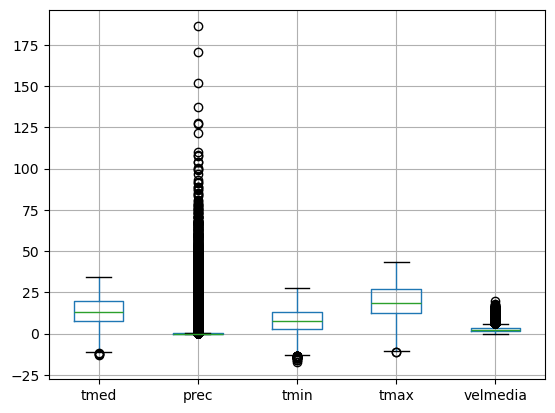

In [10]:
df_total[['tmed','prec','tmin','tmax','velmedia']].boxplot()

38.9
-11.499999999999998


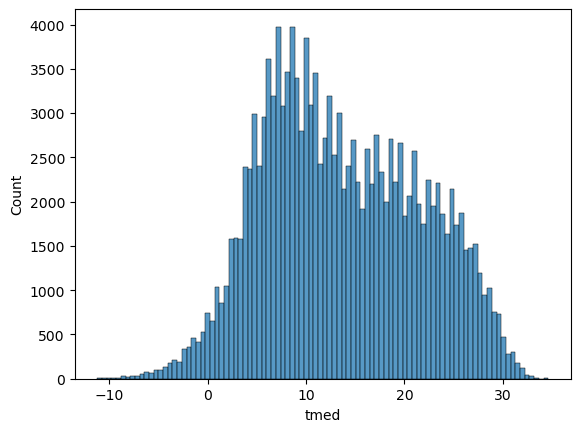

In [100]:
#empezamos con la tmed, tiene pocos outliers
q1=df_total['tmed'].quantile(0.25)
q3=df_total['tmed'].quantile(0.75)
iqr =q3 - q1
upper=q3 + 1.5*iqr
lower=q1-1.5*iqr
print(upper)
print(lower)
sns.histplot(df_total[(df_total.tmed>lower) & (df_total.tmed<upper)]['tmed'])
plt.show()
#la distribucion nos indica que los valores deben seer rellenados con la mediana

/tmp/ipykernel_136249/1264864987.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_total.tmed.fillna(df_total[(df_total.tmed>lower) & (df_total.tmed<upper)]['tmed'].median(), inplace=True) #relleno null


29.0
-13.399999999999999


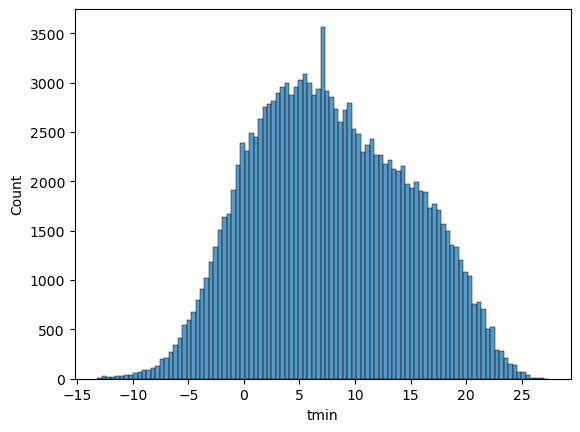

In [101]:
#rellenamos con la mediana porque la distribucion en el histograma no es nada normal
df_total.tmed.fillna(df_total[(df_total.tmed>lower) & (df_total.tmed<upper)]['tmed'].median(), inplace=True) #relleno null
#reviso ahora las tmin y tmax
q1=df_total['tmin'].quantile(0.25)
q3=df_total['tmin'].quantile(0.75)
iqr=q3-q1
upper=q3 + 1.5*iqr
lower=q1-1.5*iqr
print(upper)
print(lower)
df_total[(df_total.tmin>lower) & (df_total.tmin<upper)]['tmed']
sns.histplot(df_total[(df_total.tmin>lower) & (df_total.tmin<upper)]['tmin'])
plt.show()

/tmp/ipykernel_136249/1424918102.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_total.tmin.fillna(df_total[(df_total.tmin>lower) & (df_total.tmin<upper)]['tmin'].mean(), inplace=True)  #relleno nan


49.7
-10.3


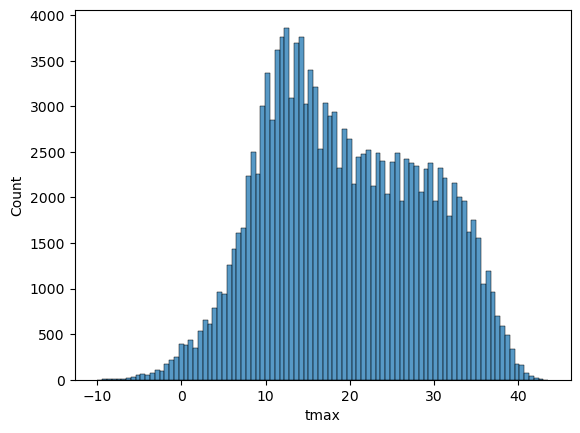

In [102]:
#despues de ver que la distribucion en tmin es bastante normal procedemos a rellenar con la media
df_total.tmin.fillna(df_total[(df_total.tmin>lower) & (df_total.tmin<upper)]['tmin'].mean(), inplace=True)  #relleno nan
#analisis de tmax
q1=df_total['tmax'].quantile(0.25)
q3=df_total['tmax'].quantile(0.75)
iqr=q3-q1
upper=q3 + 1.5*iqr
lower=q1-1.5*iqr
print(upper)
print(lower)
sns.histplot(df_total[(df_total.tmax>lower) & (df_total.tmax<upper)]['tmax'])
plt.show()

/tmp/ipykernel_136249/4083317088.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_total.tmax.fillna(df_total[(df_total.tmax>lower) & (df_total.tmax<upper)]['tmax'].median(), inplace=True)


0.8
-0.6000000000000001


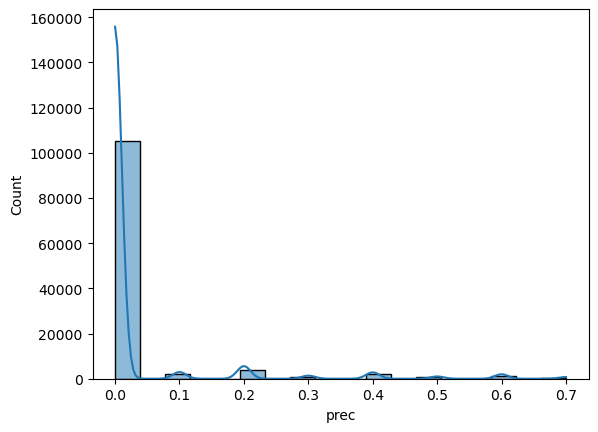

In [103]:
#mismo criterio con tmax, usamos mediana porque su distribucion no es normal
df_total.tmax.fillna(df_total[(df_total.tmax>lower) & (df_total.tmax<upper)]['tmax'].median(), inplace=True)
###ahora analizamos precipitacion para ver como rellenamos
q1=df_total['prec'].quantile(0.25)
q3=df_total['prec'].quantile(0.75)
iqr=q3-q1
upper=q3 + 3*iqr
lower=q1-3*iqr
print(upper)
print(lower)
sns.histplot(df_total[(df_total.prec>lower) & (df_total.prec<upper)]['prec'], kde=True)
plt.show()

/tmp/ipykernel_136249/3723432361.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_total.prec.fillna(df_total[(df_total.prec>lower) & (df_total.prec<upper)]['prec'].median(), inplace=True)  #aqui uso la mediana


6.1499999999999995
-1.4499999999999997


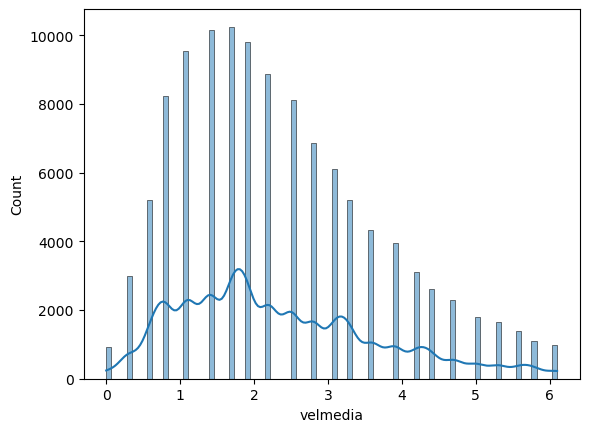

In [104]:
df_total.prec.fillna(df_total[(df_total.prec>lower) & (df_total.prec<upper)]['prec'].median(), inplace=True)  #aqui uso la mediana
##ahora vamos con velmedia del viento
q1=df_total['velmedia'].quantile(0.25)
q3=df_total['velmedia'].quantile(0.75)
iqr=q3-q1
upper=q3 + 1.5*iqr
lower=q1-1.5*iqr
print(upper)
print(lower)
sns.histplot(df_total[(df_total.velmedia>lower) & (df_total.velmedia<upper)]['velmedia'], kde=True)
plt.show()

In [105]:
df_total.velmedia.fillna(df_total[(df_total.velmedia>lower) & (df_total.velmedia<upper)]['velmedia'].median(), inplace=True)


/tmp/ipykernel_136249/4177342463.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_total.velmedia.fillna(df_total[(df_total.velmedia>lower) & (df_total.velmedia<upper)]['velmedia'].median(), inplace=True)


<Axes: >

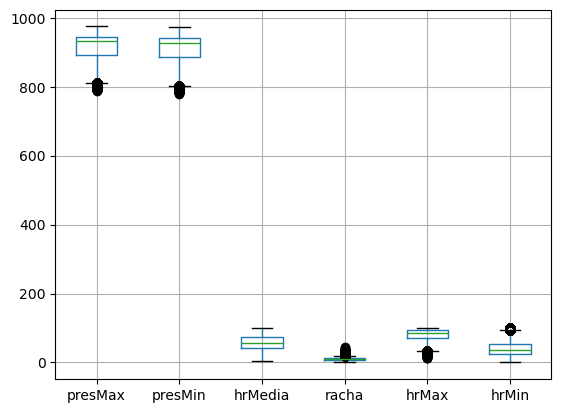

In [17]:
df_total[['presMax', 'presMin', 'hrMedia', 'racha', 'hrMax', 'hrMin']].boxplot()

In [106]:
q1=df_total['presMax'].quantile(0.25)
q3=df_total['presMax'].quantile(0.75)
iqr=q3-q1
upper=q3 + 1.5*iqr
lower=q1-1.5*iqr
print(upper)
print(lower)

1025.0500000000002
811.8499999999999


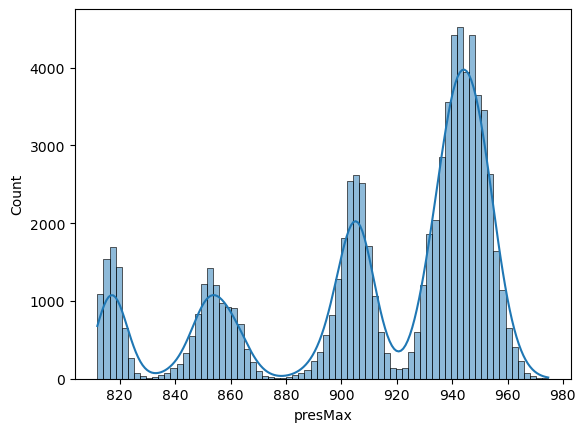

In [19]:
sns.histplot(df_total[(df_total.presMax>lower) & (df_total.presMax<upper)]['presMax'], kde=True)
plt.show()

In [107]:
#creo la columna semana_anio que nos será muy util para la regresion luego
df_total['semana_anio'] = df_total['fecha'].dt.strftime('%Y-%W')

In [108]:
#hay una formula que se usa en meteorologia para conocer la presion
# Funcion para estimar la presion basada en la altitud y otra presion de referencia
def ajustar_presion_por_altitud(presion_referencia, altitud_referencia, altitud_actual):
    if pd.isna(presion_referencia) or pd.isna(altitud_referencia):
        return np.nan
    return presion_referencia * ((1 - (altitud_actual / 44330)) / (1 - (altitud_referencia / 44330))) ** 5.255

# Calcular la presion promedio por semana y estación (donde haya datos)
presion_promedio_estaciones = df_total.groupby(['semana_anio', 'indicativo'])[['presMax', 'presMin', 'altitud']].mean()

# Rellenar presMax
for i, row in df_total[df_total['presMax'].isna()].iterrows():
    estacion = row['indicativo']
    semana1 = row['semana_anio']
    altitud_actual = row['altitud']

    # Obtener la presión promedio y altitud de la estación para esa semana
    if (semana1, estacion) in presion_promedio_estaciones.index:
        datos_referencia = presion_promedio_estaciones.loc[(semana1, estacion)]
        presion_referencia = datos_referencia['presMax']
        altitud_referencia = datos_referencia['altitud']

        # Ajustar la presión por la diferencia de altitud
        df_total.at[i, 'presMax'] = ajustar_presion_por_altitud(presion_referencia, altitud_referencia, altitud_actual)

# Rellenar presMin de manera similar
for i, row in df_total[df_total['presMin'].isna()].iterrows():
    estacion = row['indicativo']
    semana1 = row['semana_anio']
    altitud_actual = row['altitud']

    if (semana1, estacion) in presion_promedio_estaciones.index:
        datos_referencia = presion_promedio_estaciones.loc[(semana1, estacion)]
        presion_referencia = datos_referencia['presMin']
        altitud_referencia = datos_referencia['altitud']

        df_total.at[i, 'presMin'] = ajustar_presion_por_altitud(presion_referencia, altitud_referencia, altitud_actual)
#con esta funcion logro rellenar solo unos poco null (1700 aprox) asi qeu recurro a la  interpolacion lineal


#2 parte para rellenar nan de presMin y presMax, esta vez  interpolar valores faltantes de forma lineal por tiempo
df_total['presMax'] = df_total['presMax'].interpolate(method='linear', limit_direction='forward', axis=0)
df_total['presMin'] = df_total['presMin'].interpolate(method='linear', limit_direction='forward', axis=0)

# ¿Por qué es útil la interpolacion lineal?
# Suaviza las transiciones: Los valores interpolados mantienen una transición natural entre datos conocidos, lo que evita saltos bruscos o inconsistencias.
# Conserva la tendencia: Es ideal para datos secuenciales (como registros de presión diaria), ya que respeta la tendencia de los datos.
# Cuándo usarlo:
# Patrones temporales: Cuando los datos faltantes están en medio de registros conocidos y se espera que la variable cambie suavemente.
# Datos que cambian lentamente: Como la presión atmosférica, temperatura, o humedad, que no suelen tener cambios repentinos entre días consecutivos.
# ahora pasamos a rellenar los nan de 'racha', como tenemos 77% de datos podemos empezar con
# interpolacion lineal en los registros que falte un dato  

In [109]:
df_total['racha'] = df_total['racha'].interpolate(method='linear', limit_direction='forward', axis=0)
df_total['racha']=df_total['racha'].fillna(3.60) #solo queda 1 solo nan y se rellena con el promedio de ese dia los otros años
#para las hr usamos el promedio de esa misma estacion, ese mismo mes
prom_mes__hrMax = df_total.groupby(['indicativo', 'mes'])['hrMax'].transform('mean')

# Media mensual por estación para hrMin
prom_mes__hrMin = df_total.groupby(['indicativo', 'mes'])['hrMin'].transform('mean')

# Rellenar nulos restantes con las medias mensuales por estación
df_total['hrMax'].fillna(prom_mes__hrMax, inplace=True)
df_total['hrMin'].fillna(prom_mes__hrMin, inplace=True)
#y las hr faltantes (8000 aprox) con interpolacion lineal para valores consecutivos
df_total['hrMax'] = df_total['hrMax'].interpolate(method='linear', limit_direction='forward', axis=0)
df_total['hrMin'] = df_total['hrMin'].interpolate(method='linear', limit_direction='forward', axis=0)

/tmp/ipykernel_136249/2573885135.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_total['hrMax'].fillna(prom_mes__hrMax, inplace=True)
/tmp/ipykernel_136249/2573885135.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

In [ ]:
# ya con todos los nan rellenos, creamos una nueva columna donde indique la precipitacion
#acumulada durante todo el año para usarla luego en las condiciones del cultivo 

In [110]:
#calcular la suma anual de precipitacion por estacion
prec_anual = df_total.groupby(['indicativo', 'anio'])['prec'].sum().reset_index()
prec_anual.rename(columns={'prec': 'prec_anual'}, inplace=True)

# unir la columna de precipitacion anual al DataFrame original
df_total = df_total.merge(prec_anual, on=['indicativo', 'anio'], how='left')
df_total['hrMedia'] = df_total['hrMedia'].fillna((df_total['hrMin'] + df_total['hrMax']) / 2)

<Axes: >

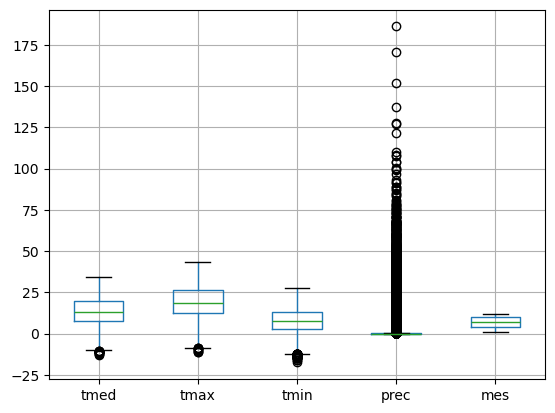

In [25]:
df_total[['tmed','tmax', 'tmin', 'prec', 'mes']].boxplot()
#evalúo los gráficos para ver si tengo outliers y re escalar 
# las columnas para un modelo de regresion lineal mas efectivo

0.4
-0.30000000000000004


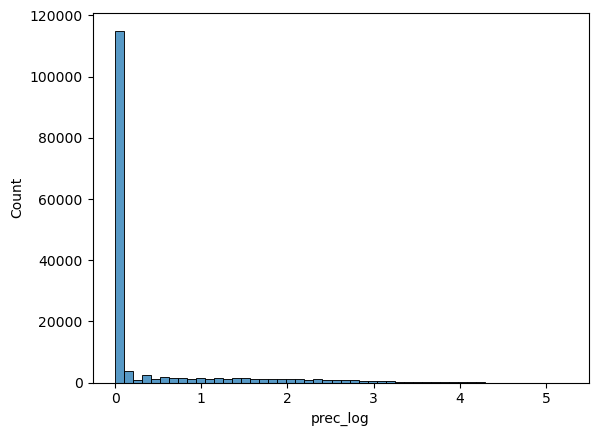

In [111]:
#empiezo con prec que tiene mas outliers a ver como mejora
q1=df_total['prec'].quantile(0.25)
q3=df_total['prec'].quantile(0.75)
iqr =q3 - q1
upper=q3 +3*iqr
lower=q1-3*iqr
print(upper)
print(lower)
robust = RobustScaler()
df_total['prec_robust'] = robust.fit_transform(df_total[['prec']])
df_total['prec_log'] = np.log1p(df_total.prec)
sns.histplot(df_total.prec_log, bins=50)
plt.show()

<Axes: >

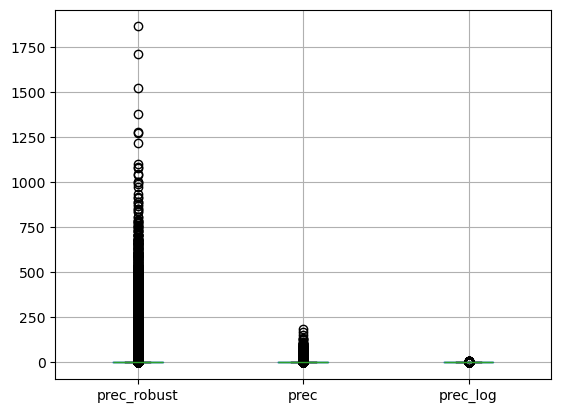

In [28]:
df_total[['prec_robust' , 'prec', 'prec_log']].boxplot()

/home/samurailoco/miniconda3/envs/proyecto/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/samurailoco/miniconda3/envs/proyecto/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

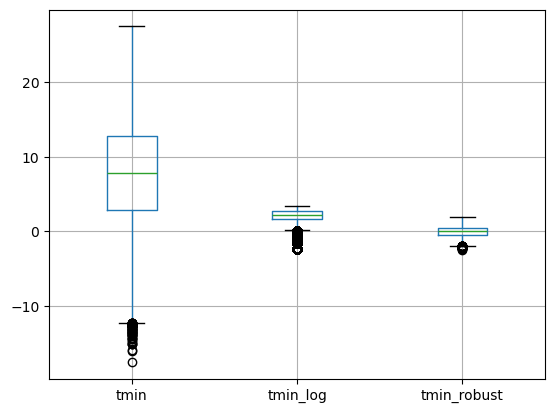

In [112]:
df_total['tmin_log'] = np.log1p(df_total.tmin)
robust = RobustScaler()
df_total['tmin_robust'] = robust.fit_transform(df_total[['tmin']])
df_total[['tmin', 'tmin_log','tmin_robust']].boxplot()
#aqui me quedo con tmin_robust

/home/samurailoco/miniconda3/envs/proyecto/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/samurailoco/miniconda3/envs/proyecto/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

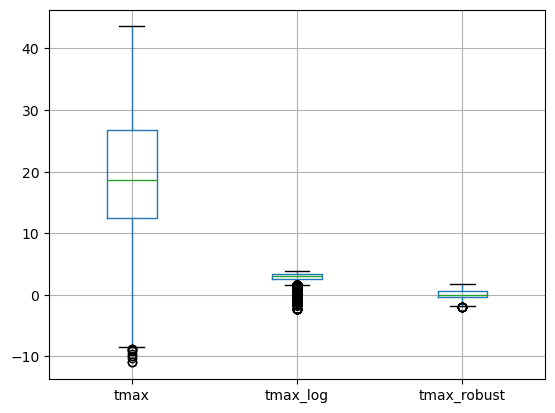

In [113]:
df_total['tmax_log'] = np.log1p(df_total.tmax)

robust = RobustScaler()
df_total['tmax_robust'] = robust.fit_transform(df_total[['tmax']])

df_total[['tmax', 'tmax_log','tmax_robust']].boxplot()
#aqui me quedo con tmax_robust

/home/samurailoco/miniconda3/envs/proyecto/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/samurailoco/miniconda3/envs/proyecto/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

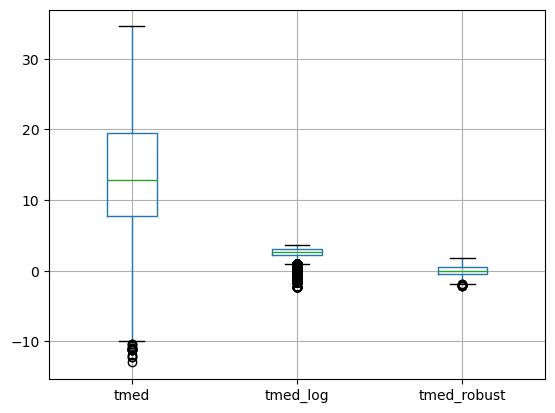

In [114]:
df_total['tmed_log'] = np.log1p(df_total.tmed)

robust = RobustScaler()
df_total['tmed_robust'] = robust.fit_transform(df_total[['tmed']])
df_total[['tmed', 'tmed_log','tmed_robust']].boxplot()
#aqui me quedo con tmed_robust

<Axes: >

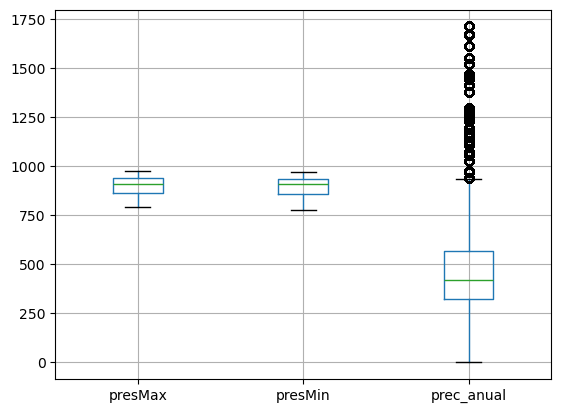

In [82]:
df_total[[ 'presMax', 'presMin', 'prec_anual' ]].boxplot()
#debemos corregir prec_anual aplicando robust o log.. probamos a ver,
#mientras que presMax y presMin se dejan como estan

<Axes: >

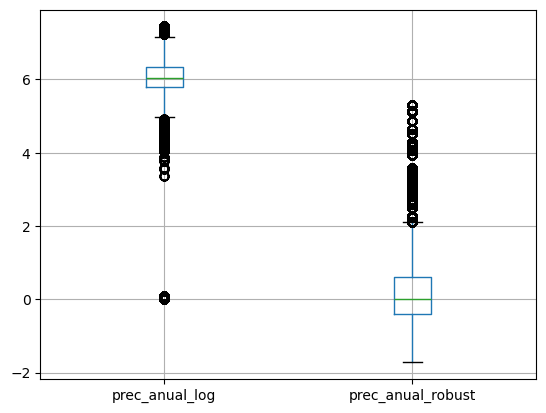

In [115]:
#empiezo a tratar las prec_anual 
df_total['prec_anual_log'] = np.log1p(df_total.prec_anual)

robust = RobustScaler()
df_total['prec_anual_robust'] = robust.fit_transform(df_total[['prec_anual']])
df_total[['prec_anual_log', 'prec_anual_robust' ]].boxplot()

<Axes: >

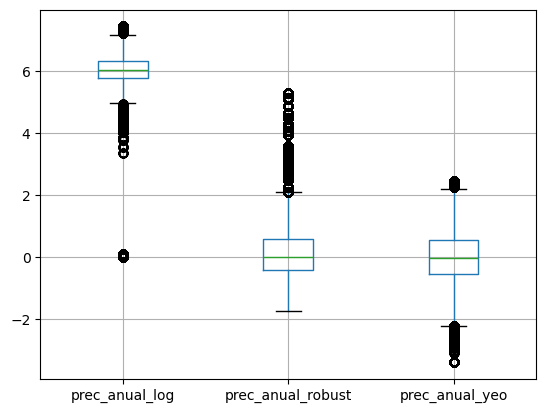

In [116]:
#no me convence el resultado de log y robust asi que pruebo con otra reescalada 'yeo' a ver que tal me va.
from sklearn.preprocessing import PowerTransformer
pt_yeojohnson = PowerTransformer(method='yeo-johnson')
df_total['prec_anual_yeo'] = pt_yeojohnson.fit_transform(df_total[['prec_anual_robust']])
df_total[['prec_anual_log', 'prec_anual_robust','prec_anual_yeo' ]].boxplot()

<Axes: xlabel='prec_anual_log', ylabel='Count'>

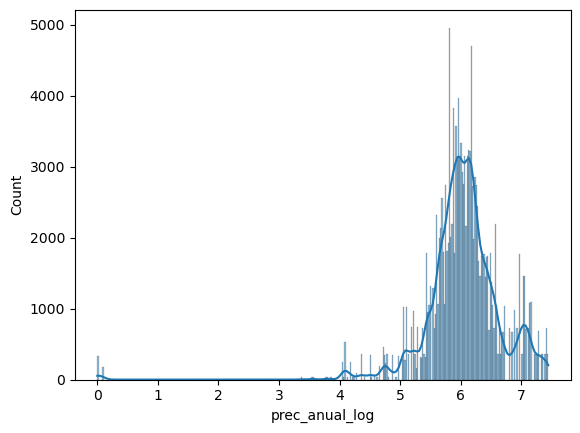

In [35]:
sns.histplot(df_total['prec_anual_log'], kde=True)

<Axes: xlabel='prec_anual_robust', ylabel='Count'>

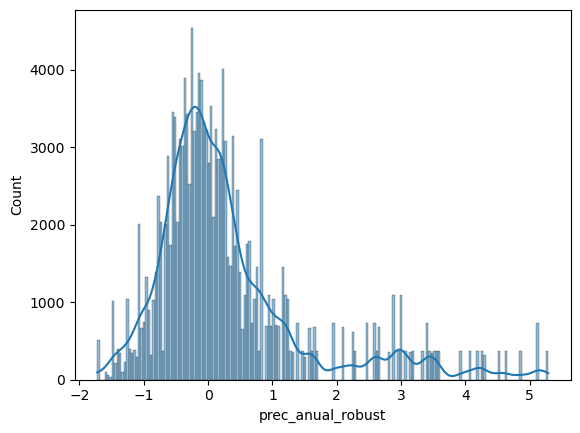

In [36]:
sns.histplot(df_total['prec_anual_robust'], kde=True)

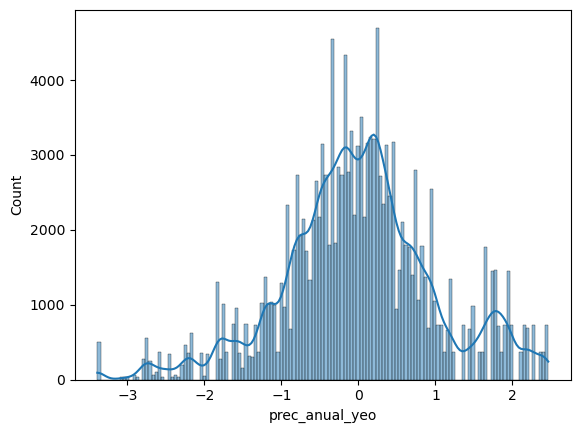

In [ ]:
sns.histplot(df_total['prec_anual_yeo'], kde=True)
plt.show()
##de la prec_anual nos quedamos con prec_anual_yeo

<Axes: >

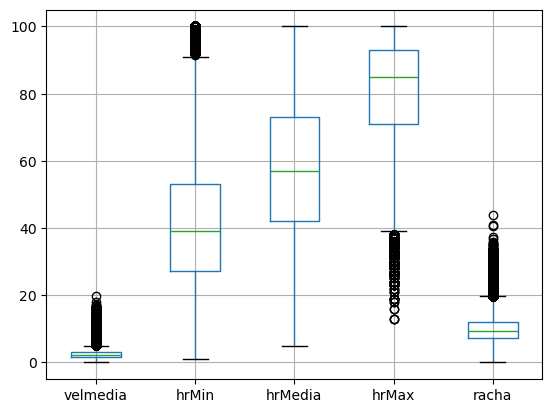

In [38]:
df_total[['velmedia', 'hrMin', 'hrMedia','hrMax', 'racha' ]].boxplot()

<Axes: >

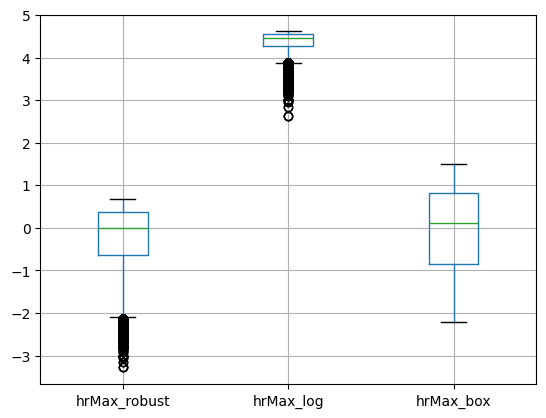

In [117]:
#probamos con hrMax 
df_total['hrMax_log'] = np.log1p(df_total.hrMax)
robust = RobustScaler()
df_total['hrMax_robust'] = robust.fit_transform(df_total[['hrMax']])
pt_boxcox = PowerTransformer(method='box-cox')
df_total['hrMax_box'] = pt_boxcox.fit_transform(df_total[['hrMax_log']])
df_total[['hrMax_robust', 'hrMax_log', 'hrMax_box' ]].boxplot()
#evidenetemente nos quedamos con hrMax_box que no tienes outliers

<Axes: >

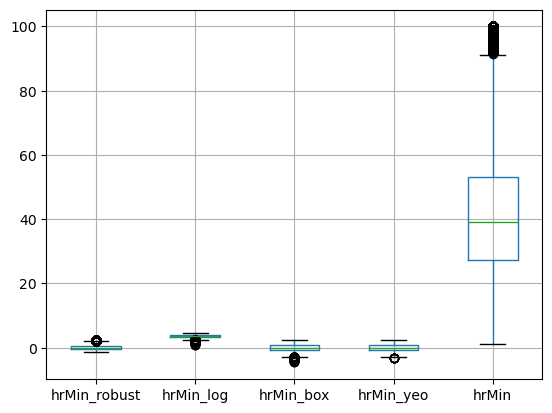

In [118]:
#probamos con hrMin 
df_total['hrMin_log'] = np.log1p(df_total.hrMin)

robust = RobustScaler()
df_total['hrMin_robust'] = robust.fit_transform(df_total[['hrMin']])
pt_yeojohnson = PowerTransformer(method='yeo-johnson')
df_total['hrMin_yeo'] = pt_yeojohnson.fit_transform(df_total[['hrMin_robust']])

pt_boxcox = PowerTransformer(method='box-cox')
df_total['hrMin_box'] = pt_boxcox.fit_transform(df_total[['hrMin_log']])

df_total[['hrMin_robust', 'hrMin_log', 'hrMin_box', 'hrMin_yeo', 'hrMin' ]].boxplot()
#aca selecciono hrMin_yeo que me queda con menos outliers

In [ ]:
##vamos ahora con la velmedia

<Axes: >

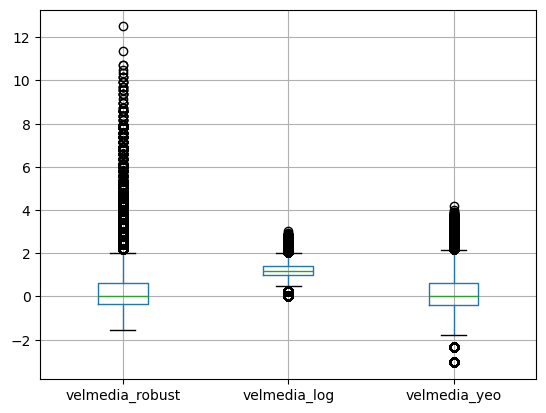

In [119]:
df_total['velmedia_log'] = np.log1p(df_total.velmedia)

robust = RobustScaler()
df_total['velmedia_robust'] = robust.fit_transform(df_total[['velmedia']])

pt_yeojohnson = PowerTransformer(method='yeo-johnson')
df_total['velmedia_yeo'] = pt_yeojohnson.fit_transform(df_total[['velmedia']])
df_total[['velmedia_robust', 'velmedia_log', 'velmedia_yeo' ]].boxplot()

<Axes: >

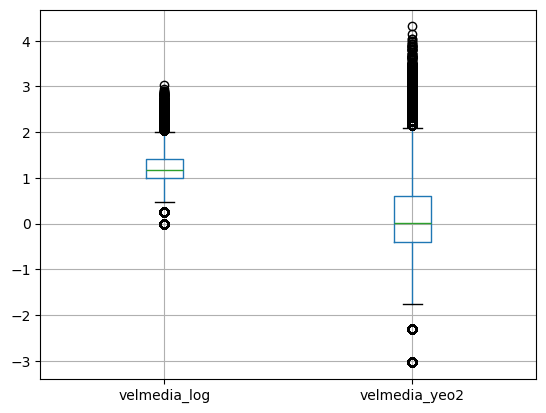

In [120]:
pt_yeojohnson = PowerTransformer(method='yeo-johnson')
df_total['velmedia_yeo2'] = pt_yeojohnson.fit_transform(df_total[['velmedia_log']])
df_total[[ 'velmedia_log', 'velmedia_yeo2' ]].boxplot()
#velmedia_log es mi mejor opcion

<Axes: >

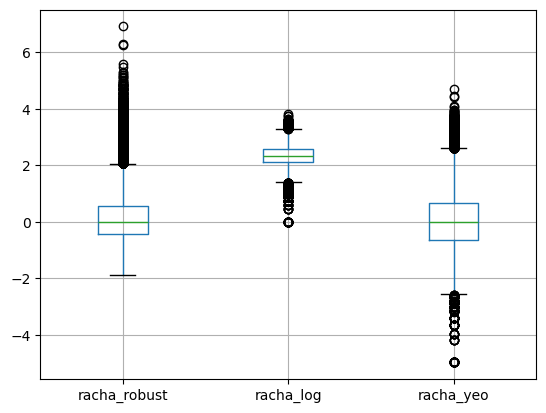

In [121]:
#vamos ahora con racha
from sklearn.preprocessing import PowerTransformer

df_total['racha_log'] = np.log1p(df_total.racha)

robust = RobustScaler()
df_total['racha_robust'] = robust.fit_transform(df_total[['racha']])

pt_yeojohnson = PowerTransformer(method='yeo-johnson')
df_total['racha_yeo'] = pt_yeojohnson.fit_transform(df_total[['racha']])
df_total[['racha_robust', 'racha_log', 'racha_yeo' ]].boxplot()

<Axes: >

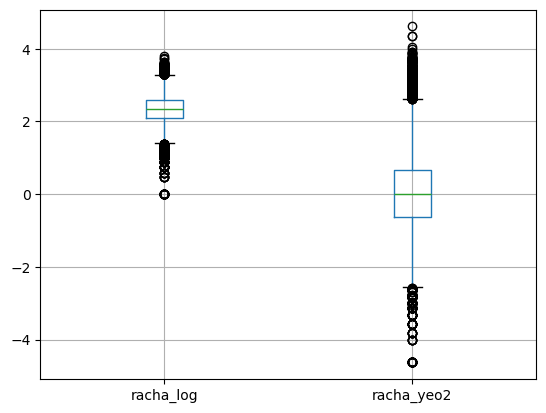

In [122]:
pt_yeojohnson = PowerTransformer(method='yeo-johnson')
df_total['racha_yeo2'] = pt_yeojohnson.fit_transform(df_total[['racha_log']])
df_total[[ 'racha_log', 'racha_yeo2' ]].boxplot()
#racha log

In [123]:
#hago un label encoder a 'nombre' para enumerar cada estacion.
le = LabelEncoder()

# Aplicar LabelEncoder a la columna 'nombre'
df_total['nombre_encoded'] = le.fit_transform(df_total['nombre'])
df_total['altitud_cat']=df_total['altitud'].astype('category')
#hago un dumie a la columna altitud
altitudcat = pd.get_dummies(df_total.altitud_cat, drop_first=False)
df_total = pd.concat([df_total, altitudcat], axis=1)

df_total.columns = df_total.columns.astype(str)

#elimino columnas que me son innecesarias
df_total = df_total.drop(columns=['horatmin', 'horatmax','horaPresMax',  'horaPresMin', 'horaracha','horaHrMax', 'horaHrMin', 'dir'])
df_total['tmax_log']=df_total['tmax_log'].fillna(df_total['tmax_log'].median())
df_total['tmin_log']=df_total['tmin_log'].fillna(df_total['tmin_log'].mean())
df_total['tmed_log']=df_total['tmed_log'].fillna(df_total['tmed_log'].median())

In [ ]:
##pruebo diferentes modelos a ver cual me da mejor r2 y es mas confiable para calcular sol

In [ ]:
#xgboost a estimador 100 2c (segunda combinacion)
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X = df_train[[ 'altitud', 'tmed', 'prec', 'tmin', 'tmax',
               'velmedia', 'presMax', 'presMin', 'hrMedia', 'hrMax', 'hrMin', 'semana',
               'anio', 'mes', 'prec_anual', 'tmax_robust',
               'prec_robust', 'prec_log', 'tmin_robust', 'tmed_robust',
               'prec_anual_log', 'prec_anual_robust', 'prec_anual_yeo',
               'hrMax_log', 'hrMax_robust', 'hrMax_box', 'hrMin_log', 'hrMin_robust',
               'hrMin_yeo', 'hrMin_box', 'velmedia_log', 'velmedia_robust',
               'velmedia_yeo', 'velmedia_yeo2', 'racha_log', 'racha_robust', 'racha_yeo',
               'racha_yeo2', '533', '540', '594', '605', '609',
               '620', '665', '667', '672', '690', '740', '763',
               '884', '890', '924', '1004', '1030', '1159', '1450',
               '1532', '1893', 'nombre_encoded' ]]

y = df_train['sol']

# (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Crear el modelo 
xgbr = xgb.XGBRegressor(n_estimators=100, random_state=42)
# Entrenar 
xgbr.fit(X_train, y_train)
y_pred_xgb = xgbr.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f'XGBoost R2: {r2_xgb}')



#bucle xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# diccionario con las combinaciones de columnas
column_sets = {
    "1C": ['prec_log','tmax_robust','tmed_robust','hrMax_box','hrMedia','hrMin_robust'],

    "2c": ['altitud', 'tmed', 'prec', 'tmin', 'tmax',
           'velmedia', 'presMax', 'presMin', 'hrMedia', 'hrMax', 'hrMin', 'semana',
           'anio', 'mes', 'prec_anual', 'tmax_robust',
           'prec_robust', 'prec_log', 'tmin_robust', 'tmed_robust',
           'prec_anual_log', 'prec_anual_robust', 'prec_anual_yeo',
           'hrMax_log', 'hrMax_robust', 'hrMax_box', 'hrMin_log', 'hrMin_robust',
           'hrMin_yeo', 'hrMin_box', 'velmedia_log', 'velmedia_robust',
           'velmedia_yeo', 'velmedia_yeo2', 'racha_log', 'racha_robust', 'racha_yeo',
           'racha_yeo2', '533', '540', '594', '605', '609',
           '620', '665', '667', '672', '690', '740', '763',
           '884', '890', '924', '1004', '1030', '1159', '1450',
           '1532', '1893', 'nombre_encoded'],
    
    "4c": ['altitud', 'tmed', 'prec', 'tmin', 'tmax', 'semana',
           'anio', 'mes', 'prec_anual', 'tmax_robust',
           'prec_robust', 'prec_log', 'tmin_robust', 'tmed_robust',
           'prec_anual_log', 'prec_anual_robust', 'prec_anual_yeo',
           'hrMax_log', 'hrMax_robust', 'hrMax_box', 'hrMin_log', 'hrMin_robust',
           'hrMin_yeo', 'hrMin_box', '533', '540', '594', '605', '609',
           '620', '665', '667', '672', '690', '740', '763',
           '884', '890', '924', '1004', '1030', '1159', '1450',
           '1532', '1893', 'nombre_encoded'],

    "5c": ['prec_log', 'tmax_robust', 'tmed_robust', 'hrMax_box', 'hrMedia', 'hrMin_robust',
           'semana', 'prec_robust', 'prec', 'presMax', 'presMin', 'tmax', 'mes'],
    
    "6c": ['prec_log', 'tmax_robust', 'hrMedia', 'semana', 'prec_robust',
           'prec', 'presMax', 'presMin', 'tmax', 'mes'],
    
    "7c": ['tmax_robust', 'hrMedia', 'semana', 'prec_robust', 'prec',
           'presMax', 'presMin', 'tmax', 'tmed_robust', 'hrMax_box', 'hrMin_robust'],
    
    "8c": ['tmax_robust', 'hrMedia', 'semana', 'prec_robust', 'prec',
           'presMax', 'presMin', 'tmax', 'tmed_robust', 'hrMax_box', 'hrMin_robust',
           'prec_log', 'mes'],
    
    "9c": ['tmed', 'prec', 'tmin', 'tmax', 'velmedia', 'presMax', 'presMin',
           'hrMax', 'hrMin', 'semana', 'mes', 'tmax_robust', 'prec_robust',
           'prec_log', 'tmin_robust', 'tmed_robust', 'hrMax_log', 'hrMax_robust',
           'hrMax_box', 'hrMin_log', 'hrMin_robust', 'hrMin_yeo', 'hrMin_box',
           '533', '540', '594', '605', '609', '620', '665', '667', '672', '690',
           '740', '763', '884', '890', '924', '1004', '1030', '1159', '1450',
           '1532', '1893']
}

# diccionario para almacenar los resultados
results = {}


for name, cols in column_sets.items():
    print(f"Probando {name} con {len(cols)} columnas.")

    
    X = df_train[cols]
    y = df_train['sol']
# 80/20
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#  modelo XGBoost
    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
# predicciones
    y_pred = model.predict(X_test)
# R2
    r2 = r2_score(y_test, y_pred)
    results[name] = r2
    print(f"R^2 de {name}: {r2:.4f}\n")
# ordenar y mostrar las mejores combinaciones
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
print("\nResultados ordenados de mejor a peor:")
for name, r2 in sorted_results:
    print(f"{name}: R^2 = {r2:.4f}")



    
#bucle forest regressor
# Diccionario con las combinaciones de columnas
column_sets = {
    "1C": ['prec_log','tmax_robust','tmed_robust','hrMax_box','hrMedia','hrMin_robust'],
    "2c": ['altitud', 'tmed', 'prec', 'tmin', 'tmax',
           'velmedia', 'presMax', 'presMin', 'hrMedia', 'hrMax', 'hrMin', 'semana',
           'anio', 'mes', 'prec_anual', 'tmax_robust',
           'prec_robust', 'prec_log', 'tmin_robust', 'tmed_robust',
           'prec_anual_log', 'prec_anual_robust', 'prec_anual_yeo',
           'hrMax_log', 'hrMax_robust', 'hrMax_box', 'hrMin_log', 'hrMin_robust',
           'hrMin_yeo', 'hrMin_box', 'velmedia_log', 'velmedia_robust',
           'velmedia_yeo', 'velmedia_yeo2', 'racha_log', 'racha_robust', 'racha_yeo',
           'racha_yeo2', '533', '540', '594', '605', '609',
           '620', '665', '667', '672', '690', '740', '763',
           '884', '890', '924', '1004', '1030', '1159', '1450',
           '1532', '1893', 'nombre_encoded'],
    "4c": ['altitud', 'tmed', 'prec', 'tmin', 'tmax', 'semana',
           'anio', 'mes', 'prec_anual', 'tmax_robust',
           'prec_robust', 'prec_log', 'tmin_robust', 'tmed_robust',
           'prec_anual_log', 'prec_anual_robust', 'prec_anual_yeo',
           'hrMax_log', 'hrMax_robust', 'hrMax_box', 'hrMin_log', 'hrMin_robust',
           'hrMin_yeo', 'hrMin_box', '533', '540', '594', '605', '609',
           '620', '665', '667', '672', '690', '740', '763',
           '884', '890', '924', '1004', '1030', '1159', '1450',
           '1532', '1893', 'nombre_encoded'],

    "5c": ['prec_log', 'tmax_robust', 'tmed_robust', 'hrMax_box', 'hrMedia', 'hrMin_robust',
           'semana', 'prec_robust', 'prec', 'presMax', 'presMin', 'tmax', 'mes'],
    
    "6c": ['prec_log', 'tmax_robust', 'hrMedia', 'semana', 'prec_robust',
           'prec', 'presMax', 'presMin', 'tmax', 'mes'],
    
    "7c": ['tmax_robust', 'hrMedia', 'semana', 'prec_robust', 'prec',
           'presMax', 'presMin', 'tmax', 'tmed_robust', 'hrMax_box', 'hrMin_robust'],
    
    "8c": ['tmax_robust', 'hrMedia', 'semana', 'prec_robust', 'prec',
           'presMax', 'presMin', 'tmax', 'tmed_robust', 'hrMax_box', 'hrMin_robust',
           'prec_log', 'mes'],
    
    "9c": ['tmed', 'prec', 'tmin', 'tmax', 'velmedia', 'presMax', 'presMin',
           'hrMax', 'hrMin', 'semana', 'mes', 'tmax_robust', 'prec_robust',
           'prec_log', 'tmin_robust', 'tmed_robust', 'hrMax_log', 'hrMax_robust',
           'hrMax_box', 'hrMin_log', 'hrMin_robust', 'hrMin_yeo', 'hrMin_box',
           '533', '540', '594', '605', '609', '620', '665', '667', '672', '690',
           '740', '763', '884', '890', '924', '1004', '1030', '1159', '1450',
           '1532', '1893']
}
# diccionario para almacenar los resultados
results = {}
for name, cols in column_sets.items():
    print(f"Probando {name} con {len(cols)} columnas.")

    X = df_train[cols]
    y = df_train['sol']
#(80/20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Modelo RandomForest
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
# Predicciones
    y_pred = model.predict(X_test)
# Calcular R2
    r2 = r2_score(y_test, y_pred)
    results[name] = r2
    print(f"R^2 de {name}: {r2:.4f}\n")
# Ordenar y mostrar las mejores combinaciones
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
print("\nResultados ordenados de mejor a peor:")
for name, r2 in sorted_results:
    print(f"{name}: R^2 = {r2:.4f}")



    
##bucle con lineal regresion
column_sets = {
    "1C": ['prec_log','tmax_robust','tmed_robust','hrMax_box','hrMedia','hrMin_robust'],
    "2c": ['altitud', 'tmed', 'prec', 'tmin', 'tmax',
           'velmedia', 'presMax', 'presMin', 'hrMedia', 'hrMax', 'hrMin', 'semana',
           'anio', 'mes', 'prec_anual', 'tmax_robust',
           'prec_robust', 'prec_log', 'tmin_robust', 'tmed_robust',
           'prec_anual_log', 'prec_anual_robust', 'prec_anual_yeo',
           'hrMax_log', 'hrMax_robust', 'hrMax_box', 'hrMin_log', 'hrMin_robust',
           'hrMin_yeo', 'hrMin_box', 'velmedia_log', 'velmedia_robust',
           'velmedia_yeo', 'velmedia_yeo2', 'racha_log', 'racha_robust', 'racha_yeo',
           'racha_yeo2', '533', '540', '594', '605', '609',
           '620', '665', '667', '672', '690', '740', '763',
           '884', '890', '924', '1004', '1030', '1159', '1450',
           '1532', '1893', 'nombre_encoded'],
    "4c": ['altitud', 'tmed', 'prec', 'tmin', 'tmax', 'semana',
           'anio', 'mes', 'prec_anual', 'tmax_robust',
           'prec_robust', 'prec_log', 'tmin_robust', 'tmed_robust',
           'prec_anual_log', 'prec_anual_robust', 'prec_anual_yeo',
           'hrMax_log', 'hrMax_robust', 'hrMax_box', 'hrMin_log', 'hrMin_robust',
           'hrMin_yeo', 'hrMin_box', '533', '540', '594', '605', '609',
           '620', '665', '667', '672', '690', '740', '763',
           '884', '890', '924', '1004', '1030', '1159', '1450',
           '1532', '1893', 'nombre_encoded'],

    "5c": ['prec_log', 'tmax_robust', 'tmed_robust', 'hrMax_box', 'hrMedia', 'hrMin_robust',
           'semana', 'prec_robust', 'prec', 'presMax', 'presMin', 'tmax', 'mes'],
    
    "6c": ['prec_log', 'tmax_robust', 'hrMedia', 'semana', 'prec_robust',
           'prec', 'presMax', 'presMin', 'tmax', 'mes'],
    
    "7c": ['tmax_robust', 'hrMedia', 'semana', 'prec_robust', 'prec',
           'presMax', 'presMin', 'tmax', 'tmed_robust', 'hrMax_box', 'hrMin_robust'],
    
    "8c": ['tmax_robust', 'hrMedia', 'semana', 'prec_robust', 'prec',
           'presMax', 'presMin', 'tmax', 'tmed_robust', 'hrMax_box', 'hrMin_robust',
           'prec_log', 'mes'],
    
    "9c": ['tmed', 'prec', 'tmin', 'tmax', 'velmedia', 'presMax', 'presMin',
           'hrMax', 'hrMin', 'semana', 'mes', 'tmax_robust', 'prec_robust',
           'prec_log', 'tmin_robust', 'tmed_robust', 'hrMax_log', 'hrMax_robust',
           'hrMax_box', 'hrMin_log', 'hrMin_robust', 'hrMin_yeo', 'hrMin_box',
           '533', '540', '594', '605', '609', '620', '665', '667', '672', '690',
           '740', '763', '884', '890', '924', '1004', '1030', '1159', '1450',
           '1532', '1893']
}
# diccionario para almacenar los resultados
results = {}
# Bucle para probar con diferentes combinaciones de columnas y el modelo LinearRegression
for name, cols in column_sets.items():
    print(f"Probando {name} con {len(cols)} columnas.")

    X = df_train[cols]
    y = df_train['sol']
# Dividir en entrenamiento y prueba (80/20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_clean = X_train.dropna()
    y_train_clean = y_train[X_train_clean.index]
# Modelo LinearRegression
    model = LinearRegression()
    model.fit(X_train_clean, y_train_clean)
# Predicciones
    y_pred = model.predict(X_test)
# Calcular R2
    r2 = r2_score(y_test, y_pred)
    results[name] = r2
    print(f"R^2 de {name}: {r2:.4f}\n")
# Ordenar y mostrar las mejores combinaciones
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

print("\nResultados ordenados de mejor a peor:")
for name, r2 in sorted_results:
    print(f"{name}: R^2 = {r2:.4f}")



    
##bucle con support vector regressor con kernel 'rbf' es mas apto para datos climaticos
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
column_sets = {
    "1C": ['prec_log','tmax_robust','tmed_robust','hrMax_box','hrMedia','hrMin_robust'],
    "2c": ['altitud', 'tmed', 'prec', 'tmin', 'tmax',
           'velmedia', 'presMax', 'presMin', 'hrMedia', 'hrMax', 'hrMin', 'semana',
           'anio', 'mes', 'prec_anual', 'tmax_robust',
           'prec_robust', 'prec_log', 'tmin_robust', 'tmed_robust',
           'prec_anual_log', 'prec_anual_robust', 'prec_anual_yeo',
           'hrMax_log', 'hrMax_robust', 'hrMax_box', 'hrMin_log', 'hrMin_robust',
           'hrMin_yeo', 'hrMin_box', 'velmedia_log', 'velmedia_robust',
           'velmedia_yeo', 'velmedia_yeo2', 'racha_log', 'racha_robust', 'racha_yeo',
           'racha_yeo2', '533', '540', '594', '605', '609',
           '620', '665', '667', '672', '690', '740', '763',
           '884', '890', '924', '1004', '1030', '1159', '1450',
           '1532', '1893', 'nombre_encoded'],
    "4c": ['altitud', 'tmed', 'prec', 'tmin', 'tmax', 'semana',
           'anio', 'mes', 'prec_anual', 'tmax_robust',
           'prec_robust', 'prec_log', 'tmin_robust', 'tmed_robust',
           'prec_anual_log', 'prec_anual_robust', 'prec_anual_yeo',
           'hrMax_log', 'hrMax_robust', 'hrMax_box', 'hrMin_log', 'hrMin_robust',
           'hrMin_yeo', 'hrMin_box', '533', '540', '594', '605', '609',
           '620', '665', '667', '672', '690', '740', '763',
           '884', '890', '924', '1004', '1030', '1159', '1450',
           '1532', '1893', 'nombre_encoded'],

    "5c": ['prec_log', 'tmax_robust', 'tmed_robust', 'hrMax_box', 'hrMedia', 'hrMin_robust',
           'semana', 'prec_robust', 'prec', 'presMax', 'presMin', 'tmax', 'mes'],
    
    "6c": ['prec_log', 'tmax_robust', 'hrMedia', 'semana', 'prec_robust',
           'prec', 'presMax', 'presMin', 'tmax', 'mes'],
    
    "7c": ['tmax_robust', 'hrMedia', 'semana', 'prec_robust', 'prec',
           'presMax', 'presMin', 'tmax', 'tmed_robust', 'hrMax_box', 'hrMin_robust'],
    
    "8c": ['tmax_robust', 'hrMedia', 'semana', 'prec_robust', 'prec',
           'presMax', 'presMin', 'tmax', 'tmed_robust', 'hrMax_box', 'hrMin_robust',
           'prec_log', 'mes'],
    
    "9c": ['tmed', 'prec', 'tmin', 'tmax', 'velmedia', 'presMax', 'presMin',
           'hrMax', 'hrMin', 'semana', 'mes', 'tmax_robust', 'prec_robust',
           'prec_log', 'tmin_robust', 'tmed_robust', 'hrMax_log', 'hrMax_robust',
           'hrMax_box', 'hrMin_log', 'hrMin_robust', 'hrMin_yeo', 'hrMin_box',
           '533', '540', '594', '605', '609', '620', '665', '667', '672', '690',
           '740', '763', '884', '890', '924', '1004', '1030', '1159', '1450',
           '1532', '1893']
}
# diccionario para almacenar los resultados
results_svr = {}
for name, cols in column_sets.items():
    print(f"Probando {name} con {len(cols)} columnas.")

    X = df_train[cols]
    y = df_train['sol']
# 80/20
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Imputar NaN si es necesario 
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
#SVR
    model = SVR(kernel='rbf')  # También puedes usar otros kernels como 'linear', 'poly', etc.
    model.fit(X_train_imputed, y_train)
# Predicciones
    y_pred = model.predict(X_test_imputed)
# calcular R2
    r2 = r2_score(y_test, y_pred)
    results_svr[name] = r2
    print(f"R^2 de {name}: {r2:.4f}\n")

sorted_results_svr = sorted(results_svr.items(), key=lambda x: x[1], reverse=True)

print("\nResultados ordenados de mejor a peor:")
for name, r2 in sorted_results_svr:
    print(f"{name}: R^2 = {r2:.4f}")


    
##bucle con support vector regressor pero en kernel linear
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
column_sets = {
    "1C": ['prec_log','tmax_robust','tmed_robust','hrMax_box','hrMedia','hrMin_robust'],
    "2c": ['altitud', 'tmed', 'prec', 'tmin', 'tmax',
           'velmedia', 'presMax', 'presMin', 'hrMedia', 'hrMax', 'hrMin', 'semana',
           'anio', 'mes', 'prec_anual', 'tmax_robust',
           'prec_robust', 'prec_log', 'tmin_robust', 'tmed_robust',
           'prec_anual_log', 'prec_anual_robust', 'prec_anual_yeo',
           'hrMax_log', 'hrMax_robust', 'hrMax_box', 'hrMin_log', 'hrMin_robust',
           'hrMin_yeo', 'hrMin_box', 'velmedia_log', 'velmedia_robust',
           'velmedia_yeo', 'velmedia_yeo2', 'racha_log', 'racha_robust', 'racha_yeo',
           'racha_yeo2', '533', '540', '594', '605', '609',
           '620', '665', '667', '672', '690', '740', '763',
           '884', '890', '924', '1004', '1030', '1159', '1450',
           '1532', '1893', 'nombre_encoded'],
    "4c": ['altitud', 'tmed', 'prec', 'tmin', 'tmax', 'semana',
           'anio', 'mes', 'prec_anual', 'tmax_robust',
           'prec_robust', 'prec_log', 'tmin_robust', 'tmed_robust',
           'prec_anual_log', 'prec_anual_robust', 'prec_anual_yeo',
           'hrMax_log', 'hrMax_robust', 'hrMax_box', 'hrMin_log', 'hrMin_robust',
           'hrMin_yeo', 'hrMin_box', '533', '540', '594', '605', '609',
           '620', '665', '667', '672', '690', '740', '763',
           '884', '890', '924', '1004', '1030', '1159', '1450',
           '1532', '1893', 'nombre_encoded'],

    "5c": ['prec_log', 'tmax_robust', 'tmed_robust', 'hrMax_box', 'hrMedia', 'hrMin_robust',
           'semana', 'prec_robust', 'prec', 'presMax', 'presMin', 'tmax', 'mes'],
    
    "6c": ['prec_log', 'tmax_robust', 'hrMedia', 'semana', 'prec_robust',
           'prec', 'presMax', 'presMin', 'tmax', 'mes'],
    
    "7c": ['tmax_robust', 'hrMedia', 'semana', 'prec_robust', 'prec',
           'presMax', 'presMin', 'tmax', 'tmed_robust', 'hrMax_box', 'hrMin_robust'],
    
    "8c": ['tmax_robust', 'hrMedia', 'semana', 'prec_robust', 'prec',
           'presMax', 'presMin', 'tmax', 'tmed_robust', 'hrMax_box', 'hrMin_robust',
           'prec_log', 'mes'],
    
    "9c": ['tmed', 'prec', 'tmin', 'tmax', 'velmedia', 'presMax', 'presMin',
           'hrMax', 'hrMin', 'semana', 'mes', 'tmax_robust', 'prec_robust',
           'prec_log', 'tmin_robust', 'tmed_robust', 'hrMax_log', 'hrMax_robust',
           'hrMax_box', 'hrMin_log', 'hrMin_robust', 'hrMin_yeo', 'hrMin_box',
           '533', '540', '594', '605', '609', '620', '665', '667', '672', '690',
           '740', '763', '884', '890', '924', '1004', '1030', '1159', '1450',
           '1532', '1893']
}
# diccionario para almacenar los resultados
results_svr = {}
for name, cols in column_sets.items():
    print(f"Probando {name} con {len(cols)} columnas.")

   
    X = df_train[cols]
    y = df_train['sol']
# 80/20
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Imputar NaN si es necesario 
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
#SVR
    model = SVR(kernel='linear')  # También puedes usar otros kernels como 'linear', 'poly', etc.
    model.fit(X_train_imputed, y_train)
# Predicciones
    y_pred = model.predict(X_test_imputed)
# Calcular R2
    r2 = r2_score(y_test, y_pred)
    results_svr[name] = r2
    print(f"R^2 de {name}: {r2:.4f}\n")

sorted_results_svr = sorted(results_svr.items(), key=lambda x: x[1], reverse=True)

print("\nResultados ordenados de mejor a peor:")
for name, r2 in sorted_results_svr:
    print(f"{name}: R^2 = {r2:.4f}")


    
#bucle con gbr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
column_sets = {
    "1C": ['prec_log','tmax_robust','tmed_robust','hrMax_box','hrMedia','hrMin_robust'],
    "2c": ['altitud', 'tmed', 'prec', 'tmin', 'tmax',
           'velmedia', 'presMax', 'presMin', 'hrMedia', 'hrMax', 'hrMin', 'semana',
           'anio', 'mes', 'prec_anual', 'tmax_robust',
           'prec_robust', 'prec_log', 'tmin_robust', 'tmed_robust',
           'prec_anual_log', 'prec_anual_robust', 'prec_anual_yeo',
           'hrMax_log', 'hrMax_robust', 'hrMax_box', 'hrMin_log', 'hrMin_robust',
           'hrMin_yeo', 'hrMin_box', 'velmedia_log', 'velmedia_robust',
           'velmedia_yeo', 'velmedia_yeo2', 'racha_log', 'racha_robust', 'racha_yeo',
           'racha_yeo2', '533', '540', '594', '605', '609',
           '620', '665', '667', '672', '690', '740', '763',
           '884', '890', '924', '1004', '1030', '1159', '1450',
           '1532', '1893', 'nombre_encoded'],
       "3C": ['altitud', 'prec', 'hrMedia', 'semana', 'mes'],
    "4c": ['altitud', 'tmed', 'prec', 'tmin', 'tmax', 'semana',
           'anio', 'mes', 'prec_anual', 'tmax_robust',
           'prec_robust', 'prec_log', 'tmin_robust', 'tmed_robust',
           'prec_anual_log', 'prec_anual_robust', 'prec_anual_yeo',
           'hrMax_log', 'hrMax_robust', 'hrMax_box', 'hrMin_log', 'hrMin_robust',
           'hrMin_yeo', 'hrMin_box', '533', '540', '594', '605', '609',
           '620', '665', '667', '672', '690', '740', '763',
           '884', '890', '924', '1004', '1030', '1159', '1450',
           '1532', '1893', 'nombre_encoded'],

    "5c": ['prec_log', 'tmax_robust', 'tmed_robust', 'hrMax_box', 'hrMedia', 'hrMin_robust',
           'semana', 'prec_robust', 'prec', 'presMax', 'presMin', 'tmax', 'mes'],
    
    "6c": ['prec_log', 'tmax_robust', 'hrMedia', 'semana', 'prec_robust',
           'prec', 'presMax', 'presMin', 'tmax', 'mes'],
    
    "7c": ['tmax_robust', 'hrMedia', 'semana', 'prec_robust', 'prec',
           'presMax', 'presMin', 'tmax', 'tmed_robust', 'hrMax_box', 'hrMin_robust'],
    
    "8c": ['tmax_robust', 'hrMedia', 'semana', 'prec_robust', 'prec',
           'presMax', 'presMin', 'tmax', 'tmed_robust', 'hrMax_box', 'hrMin_robust',
           'prec_log', 'mes'],
    
    "9c": ['tmed', 'prec', 'tmin', 'tmax', 'velmedia', 'presMax', 'presMin',
           'hrMax', 'hrMin', 'semana', 'mes', 'tmax_robust', 'prec_robust',
           'prec_log', 'tmin_robust', 'tmed_robust', 'hrMax_log', 'hrMax_robust',
           'hrMax_box', 'hrMin_log', 'hrMin_robust', 'hrMin_yeo', 'hrMin_box',
           '533', '540', '594', '605', '609', '620', '665', '667', '672', '690',
           '740', '763', '884', '890', '924', '1004', '1030', '1159', '1450',
           '1532', '1893']
}
results_gbr = {}
for name, cols in column_sets.items():
    print(f"Probando {name} con {len(cols)} columnas.")
    
    X = df_train[cols]
    y = df_train['sol']
# (80/20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    X_train = X_train.fillna(X_train.median())
    X_test = X_test.fillna(X_train.median())
# Modelo Gradient Boosting Regressor
    model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    

    y_pred = model.predict(X_test)
# calcular R2
    r2 = r2_score(y_test, y_pred)
    results_gbr[name] = r2
    print(f"R^2 de {name}: {r2:.4f}\n")

# Ordenar y mostrar las mejores combinaciones
sorted_results_gbr = sorted(results_gbr.items(), key=lambda x: x[1], reverse=True)

print("\nResultados ordenados de mejor a peor:")
for name, r2 in sorted_results_gbr:
    print(f"{name}: R^2 = {r2:.4f}")

    

#bucle con catboost
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
column_sets = {
    "1C": ['prec_log','tmax_robust','tmed_robust','hrMax_box','hrMedia','hrMin_robust'],
    "2c": [ 'altitud', 'tmed', 'prec', 'tmin', 'tmax',
           'velmedia', 'presMax', 'presMin', 'hrMedia', 'hrMax', 'hrMin', 'semana',
           'anio', 'mes', 'prec_anual', 'tmax_robust',
           'prec_robust', 'prec_log', 'tmin_robust', 'tmed_robust',
           'prec_anual_log', 'prec_anual_robust', 'prec_anual_yeo',
           'hrMax_log', 'hrMax_robust', 'hrMax_box', 'hrMin_log', 'hrMin_robust',
           'hrMin_yeo', 'hrMin_box', 'velmedia_log', 'velmedia_robust',
           'velmedia_yeo', 'velmedia_yeo2', 'racha_log', 'racha_robust', 'racha_yeo',
           'racha_yeo2', '533', '540', '594', '605', '609',
           '620', '665', '667', '672', '690', '740', '763',
           '884', '890', '924', '1004', '1030', '1159', '1450',
           '1532', '1893', 'nombre_encoded'],
       "3C": ['altitud', 'prec', 'hrMedia', 'semana', 'mes'],
    "4c": ['altitud', 'tmed', 'prec', 'tmin', 'tmax', 'semana',
           'anio', 'mes', 'prec_anual', 'tmax_robust',
           'prec_robust', 'prec_log', 'tmin_robust', 'tmed_robust',
           'prec_anual_log', 'prec_anual_robust', 'prec_anual_yeo',
           'hrMax_log', 'hrMax_robust', 'hrMax_box', 'hrMin_log', 'hrMin_robust',
           'hrMin_yeo', 'hrMin_box', '533', '540', '594', '605', '609',
           '620', '665', '667', '672', '690', '740', '763',
           '884', '890', '924', '1004', '1030', '1159', '1450',
           '1532', '1893', 'nombre_encoded'],

    "5c": ['prec_log', 'tmax_robust', 'tmed_robust', 'hrMax_box', 'hrMedia', 'hrMin_robust',
           'semana', 'prec_robust', 'prec', 'presMax', 'presMin', 'tmax', 'mes'],
    
    "6c": ['prec_log', 'tmax_robust', 'hrMedia', 'semana', 'prec_robust',
           'prec', 'presMax', 'presMin', 'tmax', 'mes'],
    
    "7c": ['tmax_robust', 'hrMedia', 'semana', 'prec_robust', 'prec',
           'presMax', 'presMin', 'tmax', 'tmed_robust', 'hrMax_box', 'hrMin_robust'],
    
    "8c": ['tmax_robust', 'hrMedia', 'semana', 'prec_robust', 'prec',
           'presMax', 'presMin', 'tmax', 'tmed_robust', 'hrMax_box', 'hrMin_robust',
           'prec_log', 'mes'],
    
    "9c": ['tmed', 'prec', 'tmin', 'tmax', 'velmedia', 'presMax', 'presMin',
           'hrMax', 'hrMin', 'semana', 'mes', 'tmax_robust', 'prec_robust',
           'prec_log', 'tmin_robust', 'tmed_robust', 'hrMax_log', 'hrMax_robust',
           'hrMax_box', 'hrMin_log', 'hrMin_robust', 'hrMin_yeo', 'hrMin_box',
           '533', '540', '594', '605', '609', '620', '665', '667', '672', '690',
           '740', '763', '884', '890', '924', '1004', '1030', '1159', '1450',
           '1532', '1893']
}
# Diccionario para almacenar los resultados
results = {}

for name, cols in column_sets.items():
    print(f"Probando {name} con {len(cols)} columnas.")

    X = df_train[cols]
    y = df_train['sol']
#(80/20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_clean = X_train.dropna()
    y_train_clean = y_train.loc[X_train_clean.index]

    model = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=6, verbose=100, random_state=42)
    model.fit(X_train_clean, y_train_clean, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=100)

    y_pred = model.predict(X_test)
#  R2
    r2 = r2_score(y_test, y_pred)
    results[name] = r2
    print(f"R^2 de {name}: {r2:.4f}\n")

# Ordenar y mostrar las mejores combinaciones
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

print("\nResultados ordenados de mejor a peor:")
for name, r2 in sorted_results:
    print(f"{name}: R^2 = {r2:.4f}")


    
#bucle con leightgbm 
from lightgbm import LGBMRegressor


column_sets = {
    "1C": ['prec_log','tmax_robust','tmed_robust','hrMax_box','hrMedia','hrMin_robust'],
    "2c": [ 'altitud', 'tmed', 'prec', 'tmin', 'tmax',
           'velmedia', 'presMax', 'presMin', 'hrMedia', 'hrMax', 'hrMin', 'semana',
           'anio', 'mes', 'prec_anual', 'tmax_robust',
           'prec_robust', 'prec_log', 'tmin_robust', 'tmed_robust',
           'prec_anual_log', 'prec_anual_robust', 'prec_anual_yeo',
           'hrMax_log', 'hrMax_robust', 'hrMax_box', 'hrMin_log', 'hrMin_robust',
           'hrMin_yeo', 'hrMin_box', 'velmedia_log', 'velmedia_robust',
           'velmedia_yeo', 'velmedia_yeo2', 'racha_log', 'racha_robust', 'racha_yeo',
           'racha_yeo2', '533', '540', '594', '605', '609',
           '620', '665', '667', '672', '690', '740', '763',
           '884', '890', '924', '1004', '1030', '1159', '1450',
           '1532', '1893', 'nombre_encoded'],
    "3C": ['altitud', 'prec', 'hrMedia', 'semana', 'mes'],
    "4c": ['altitud', 'tmed', 'prec', 'tmin', 'tmax', 'semana',
           'anio', 'mes', 'prec_anual', 'tmax_robust',
           'prec_robust', 'prec_log', 'tmin_robust', 'tmed_robust',
           'prec_anual_log', 'prec_anual_robust', 'prec_anual_yeo',
           'hrMax_log', 'hrMax_robust', 'hrMax_box', 'hrMin_log', 'hrMin_robust',
           'hrMin_yeo', 'hrMin_box', '533', '540', '594', '605', '609',
           '620', '665', '667', '672', '690', '740', '763',
           '884', '890', '924', '1004', '1030', '1159', '1450',
           '1532', '1893', 'nombre_encoded'],
    "5c": ['prec_log', 'tmax_robust', 'tmed_robust', 'hrMax_box', 'hrMedia', 'hrMin_robust',
           'semana', 'prec_robust', 'prec', 'presMax', 'presMin', 'tmax', 'mes'],
    "6c": ['prec_log', 'tmax_robust', 'hrMedia', 'semana', 'prec_robust',
           'prec', 'presMax', 'presMin', 'tmax', 'mes'],
    "7c": ['tmax_robust', 'hrMedia', 'semana', 'prec_robust', 'prec',
           'presMax', 'presMin', 'tmax', 'tmed_robust', 'hrMax_box', 'hrMin_robust'],
    "8c": ['tmax_robust', 'hrMedia', 'semana', 'prec_robust', 'prec',
           'presMax', 'presMin', 'tmax', 'tmed_robust', 'hrMax_box', 'hrMin_robust',
           'prec_log', 'mes'],
    "9c": ['tmed', 'prec', 'tmin', 'tmax', 'velmedia', 'presMax', 'presMin',
           'hrMax', 'hrMin', 'semana', 'mes', 'tmax_robust', 'prec_robust',
           'prec_log', 'tmin_robust', 'tmed_robust', 'hrMax_log', 'hrMax_robust',
           'hrMax_box', 'hrMin_log', 'hrMin_robust', 'hrMin_yeo', 'hrMin_box',
           '533', '540', '594', '605', '609', '620', '665', '667', '672', '690',
           '740', '763', '884', '890', '924', '1004', '1030', '1159', '1450',
           '1532', '1893']
}

results = {}

for name, cols in column_sets.items():
    print(f"Probando {name} con {len(cols)} columnas.")

    X = df_train[cols]
    y = df_train['sol']
#(80/20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    X_train_clean = X_train.dropna()
    y_train_clean = y_train.loc[X_train_clean.index]
#LGBMRegressor
    model = LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=5)

    model.fit(X_train_clean, y_train_clean, 
              eval_set=[(X_test, y_test)])


    y_pred = model.predict(X_test)
#R2
    r2 = r2_score(y_test, y_pred)
    results[name] = r2
    print(f"R^2 de {name}: {r2:.4f}\n")

# Ordenar y mostrar las mejores combinaciones
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

print("\nResultados ordenados de mejor a peor:")
for name, r2 in sorted_results:
    print(f"{name}: R^2 = {r2:.4f}")


    
#bucle con MLPRegressor
from sklearn.neural_network import MLPRegressor


column_sets = {
    "1C": ['prec_log','tmax_robust','tmed_robust','hrMax_box','hrMedia','hrMin_robust'],
    "2c": [ 'altitud', 'tmed', 'prec', 'tmin', 'tmax',
           'velmedia', 'presMax', 'presMin', 'hrMedia', 'hrMax', 'hrMin', 'semana',
           'anio', 'mes', 'prec_anual', 'tmax_robust',
           'prec_robust', 'prec_log', 'tmin_robust', 'tmed_robust',
           'prec_anual_log', 'prec_anual_robust', 'prec_anual_yeo',
           'hrMax_log', 'hrMax_robust', 'hrMax_box', 'hrMin_log', 'hrMin_robust',
           'hrMin_yeo', 'hrMin_box', 'velmedia_log', 'velmedia_robust',
           'velmedia_yeo', 'velmedia_yeo2', 'racha_log', 'racha_robust', 'racha_yeo',
           'racha_yeo2', '533', '540', '594', '605', '609',
           '620', '665', '667', '672', '690', '740', '763',
           '884', '890', '924', '1004', '1030', '1159', '1450',
           '1532', '1893', 'nombre_encoded'],
    "3C": ['altitud', 'prec', 'hrMedia', 'semana', 'mes'],
    "4c": ['altitud', 'tmed', 'prec', 'tmin', 'tmax', 'semana',
           'anio', 'mes', 'prec_anual', 'tmax_robust',
           'prec_robust', 'prec_log', 'tmin_robust', 'tmed_robust',
           'prec_anual_log', 'prec_anual_robust', 'prec_anual_yeo',
           'hrMax_log', 'hrMax_robust', 'hrMax_box', 'hrMin_log', 'hrMin_robust',
           'hrMin_yeo', 'hrMin_box', '533', '540', '594', '605', '609',
           '620', '665', '667', '672', '690', '740', '763',
           '884', '890', '924', '1004', '1030', '1159', '1450',
           '1532', '1893', 'nombre_encoded'],
    "5c": ['prec_log', 'tmax_robust', 'tmed_robust', 'hrMax_box', 'hrMedia', 'hrMin_robust',
           'semana', 'prec_robust', 'prec', 'presMax', 'presMin', 'tmax', 'mes'],
    "6c": ['prec_log', 'tmax_robust', 'hrMedia', 'semana', 'prec_robust',
           'prec', 'presMax', 'presMin', 'tmax', 'mes'],
    "7c": ['tmax_robust', 'hrMedia', 'semana', 'prec_robust', 'prec',
           'presMax', 'presMin', 'tmax', 'tmed_robust', 'hrMax_box', 'hrMin_robust'],
    "8c": ['tmax_robust', 'hrMedia', 'semana', 'prec_robust', 'prec',
           'presMax', 'presMin', 'tmax', 'tmed_robust', 'hrMax_box', 'hrMin_robust',
           'prec_log', 'mes'],
    "9c": ['tmed', 'prec', 'tmin', 'tmax', 'velmedia', 'presMax', 'presMin',
           'hrMax', 'hrMin', 'semana', 'mes', 'tmax_robust', 'prec_robust',
           'prec_log', 'tmin_robust', 'tmed_robust', 'hrMax_log', 'hrMax_robust',
           'hrMax_box', 'hrMin_log', 'hrMin_robust', 'hrMin_yeo', 'hrMin_box',
           '533', '540', '594', '605', '609', '620', '665', '667', '672', '690',
           '740', '763', '884', '890', '924', '1004', '1030', '1159', '1450',
           '1532', '1893']
}




results = {}

for name, cols in column_sets.items():
    print(f"Probando {name} con {len(cols)} columnas.")

    X = df_train[cols]
    y = df_train['sol']
#(80/20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_clean = X_train.dropna()
    y_train_clean = y_train.loc[X_train_clean.index]

    model = MLPRegressor(hidden_layer_sizes=(100,50), activation='relu', solver='adam', max_iter=500)

    model.fit(X_train_clean, y_train_clean)

    y_pred = model.predict(X_test)
#R2
    r2 = r2_score(y_test, y_pred)
    results[name] = r2
    print(f"R^2 de {name}: {r2:.4f}\n")

# Ordenar y mostrar las mejores combinaciones
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

print("\nResultados ordenados de mejor a peor:")
for name, r2 in sorted_results:
    print(f"{name}: R^2 = {r2:.4f}")

In [124]:
df_train = df_total.dropna(subset=['sol'])
#usamos las mejores estrategias para predecir varias columnas 'sol' y al final promediarlas todas en una sola columna definitiva
#estrategia 1 para rellenar sol
#modelo LGBMRegressor con C2 y n_estimators=500, learning_rate=0.05, max_depth=5
from lightgbm import LGBMRegressor, early_stopping
from sklearn.model_selection import train_test_split


df_nan = df_total[df_total['sol'].isnull()]


X = df_total[['altitud', 'tmed', 'prec', 'tmin', 'tmax', 'velmedia', 'presMax', 'presMin', 
              'hrMedia', 'hrMax', 'hrMin', 'semana', 'anio', 'mes', 'prec_anual', 'tmax_robust',
              'prec_robust', 'prec_log', 'tmin_robust', 'tmed_robust', 'prec_anual_log', 
              'prec_anual_robust', 'prec_anual_yeo', 'hrMax_log', 'hrMax_robust', 'hrMax_box', 
              'hrMin_log', 'hrMin_robust', 'hrMin_yeo', 'hrMin_box', 'velmedia_log', 'velmedia_robust', 
              'velmedia_yeo', 'velmedia_yeo2', 'racha_log', 'racha_robust', 'racha_yeo', 'racha_yeo2',
              '533', '540', '594', '605', '609', '620', '665', '667', '672', '690', '740', '763', 
              '884', '890', '924', '1004', '1030', '1159', '1450', '1532', '1893', 'nombre_encoded']]

y = df_total['sol']

#(80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

 
X_train_clean = X_train.dropna()
y_train_clean = y_train.loc[X_train_clean.index]



# LGBMRegressor
model = LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=5)


callbacks = [early_stopping(stopping_rounds=50)]


model.fit(X_train_clean, y_train_clean, 
          eval_set=[(X_test, y_test)], 
          eval_metric='l2', 
          callbacks=callbacks)


X_nan = df_nan[X_train_clean.columns]


predicciones_sol = model.predict(X_nan)
predicciones_sol = np.maximum(predicciones_sol, 0)  #(con esto quizas puedo obtener valores mayores a cero)


df_total['sol_full'] = df_total['sol'].copy()  
df_total.loc[df_total['sol'].isnull(), 'sol_full'] = predicciones_sol  
#2 estrategia
df_nan = df_total[df_total['sol'].isnull()]


columnas_deseadas = ['altitud', 'tmed', 'prec', 'tmin', 'tmax', 'velmedia', 'presMax', 'presMin', 
                      'hrMedia', 'hrMax', 'hrMin', 'semana', 'anio', 'mes', 'prec_anual', 'tmax_robust',
                      'prec_robust', 'prec_log', 'tmin_robust', 'tmed_robust', 'prec_anual_log', 
                      'prec_anual_robust', 'prec_anual_yeo', 'hrMax_log', 'hrMax_robust', 'hrMax_box', 
                      'hrMin_log', 'hrMin_robust', 'hrMin_yeo', 'hrMin_box', 'velmedia_log', 'velmedia_robust', 
                      'velmedia_yeo', 'velmedia_yeo2', 'racha_log', 'racha_robust', 'racha_yeo', 'racha_yeo2',
                      '533', '540', '594', '605', '609', '620', '665', '667', '672', '690', '740', '763', 
                      '884', '890', '924', '1004', '1030', '1159', '1450', '1532', '1893', 'nombre_encoded']


columnas_existentes = [col for col in columnas_deseadas if col in df_total.columns]
X = df_total[columnas_existentes].copy()
y = np.log1p(df_total['sol']).fillna(0)  # Aplicar transformación logarítmica evitando NaN

#80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_clean = X_train.dropna()
y_train_clean = y_train.loc[X_train_clean.index]


X_test_clean = X_test.dropna()
y_test_clean = y_test.loc[X_test_clean.index]

# # Entrenar el modelo
model = LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=5)
callbacks = [early_stopping(stopping_rounds=50)]

model.fit(X_train_clean, y_train_clean, 
           eval_set=[(X_test_clean, y_test_clean)],  # Evaluación en datos limpios
           eval_metric='l2', 
           callbacks=callbacks)

# # Predecir valores faltantes de 'sol' con el modelo
X_nan = df_nan[X.columns]  # Asegurar que se usen las mismas columnas del modelo
predicciones_sol_log = model.predict(X_nan)
predicciones_sol = np.maximum(predicciones_sol, 0)

# # Aplicar la transformación inversa (expm1) para regresar a la escala original
predicciones_sol = np.expm1(predicciones_sol_log)  # exp(sol_log) - 1
predicciones_sol = np.maximum(predicciones_sol, 0)
# # Crear nueva columna 'sol_full' con los valores originales de 'sol'
df_total['sol_full2'] = df_total['sol'].copy()

# # Reemplazar NaN en 'sol_full' con las predicciones
df_total.loc[df_total['sol'].isnull(), 'sol_full2'] = predicciones_sol
#la 3 estrategia 
df_nan = df_total[df_total['sol'].isnull()]


X = df_total[['altitud', 'tmed', 'prec', 'tmin', 'tmax', 'velmedia', 'presMax', 'presMin', 
              'hrMedia', 'hrMax', 'hrMin', 'semana', 'anio', 'mes', 'prec_anual', 'tmax_robust',
              'prec_robust', 'prec_log', 'tmin_robust', 'tmed_robust', 'prec_anual_log', 
              'prec_anual_robust', 'prec_anual_yeo', 'hrMax_log', 'hrMax_robust', 'hrMax_box', 
              'hrMin_log', 'hrMin_robust', 'hrMin_yeo', 'hrMin_box', 'velmedia_log', 'velmedia_robust', 
              'velmedia_yeo', 'velmedia_yeo2', 'racha_log', 'racha_robust', 'racha_yeo', 'racha_yeo2',
              '533', '540', '594', '605', '609', '620', '665', '667', '672', '690', '740', '763', 
              '884', '890', '924', '1004', '1030', '1159', '1450', '1532', '1893', 'nombre_encoded']]

y = df_total['sol']

#(80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

 
X_train_clean = X_train.dropna()
y_train_clean = y_train.loc[X_train_clean.index]



# LGBMRegressor
model = LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, min_child_weight=15) #con min_child_weight = 1 no funciona, con 10 tampoco


callbacks = [early_stopping(stopping_rounds=50)]


model.fit(X_train_clean, y_train_clean, 
          eval_set=[(X_test, y_test)], 
          eval_metric='l2', 
          callbacks=callbacks)


X_nan = df_nan[X_train_clean.columns]


predicciones_sol = model.predict(X_nan)
predicciones_sol = np.maximum(predicciones_sol, 0)

df_total['sol_full3'] = df_total['sol'].copy()  
df_total.loc[df_total['sol'].isnull(), 'sol_full3'] = predicciones_sol  
#4 estrategia
df_nan = df_total[df_total['sol'].isnull()]


X = df_total[['altitud', 'tmed', 'prec', 'tmin', 'tmax', 'velmedia', 'presMax', 'presMin', 
              'hrMedia', 'hrMax', 'hrMin', 'semana', 'anio', 'mes', 'prec_anual', 'tmax_robust',
              'prec_robust', 'prec_log', 'tmin_robust', 'tmed_robust', 'prec_anual_log', 
              'prec_anual_robust', 'prec_anual_yeo', 'hrMax_log', 'hrMax_robust', 'hrMax_box', 
              'hrMin_log', 'hrMin_robust', 'hrMin_yeo', 'hrMin_box', 'velmedia_log', 'velmedia_robust', 
              'velmedia_yeo', 'velmedia_yeo2', 'racha_log', 'racha_robust', 'racha_yeo', 'racha_yeo2',
              '533', '540', '594', '605', '609', '620', '665', '667', '672', '690', '740', '763', 
              '884', '890', '924', '1004', '1030', '1159', '1450', '1532', '1893', 'nombre_encoded']]

y = df_total['sol']

#(80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

 
X_train_clean = X_train.dropna()
y_train_clean = y_train.loc[X_train_clean.index]

def custom_loss(y_true, y_pred):
    error = (y_true - y_pred) ** 2  # MSE básico
    penalizacion = np.where(y_pred < 0, 100, 0)  # Penaliza predicciones negativas
    return 'custom_loss', np.mean(error + penalizacion), False

# LGBMRegressor
model = LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=5) 


callbacks = [early_stopping(stopping_rounds=50)]


model.fit(X_train_clean, y_train_clean, 
          eval_set=[(X_test, y_test)], 
          eval_metric='l2', 
          callbacks=callbacks)


X_nan = df_nan[X_train_clean.columns]


predicciones_sol = model.predict(X_nan)
predicciones_sol = np.maximum(predicciones_sol, 0)

df_total['sol_full4'] = df_total['sol'].copy()  
df_total.loc[df_total['sol'].isnull(), 'sol_full4'] = predicciones_sol  
#5 estrategia
df_nan = df_total[df_total['sol'].isnull()]


X = df_total[['altitud', 'tmed', 'prec', 'tmin', 'tmax', 'velmedia', 'presMax', 'presMin', 
              'hrMedia', 'hrMax', 'hrMin', 'semana', 'anio', 'mes', 'prec_anual', 'tmax_robust',
              'prec_robust', 'prec_log', 'tmin_robust', 'tmed_robust', 'prec_anual_log', 
              'prec_anual_robust', 'prec_anual_yeo', 'hrMax_log', 'hrMax_robust', 'hrMax_box', 
              'hrMin_log', 'hrMin_robust', 'hrMin_yeo', 'hrMin_box', 'velmedia_log', 'velmedia_robust', 
              'velmedia_yeo', 'velmedia_yeo2', 'racha_log', 'racha_robust', 'racha_yeo', 'racha_yeo2',
              '533', '540', '594', '605', '609', '620', '665', '667', '672', '690', '740', '763', 
              '884', '890', '924', '1004', '1030', '1159', '1450', '1532', '1893', 'nombre_encoded']]

y = df_total['sol']

#(80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

 
X_train_clean = X_train.dropna()
y_train_clean = y_train.loc[X_train_clean.index]



# LGBMRegressor
model = LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, objective='poisson')


callbacks = [early_stopping(stopping_rounds=50)]


model.fit(X_train_clean, y_train_clean, 
          eval_set=[(X_test, y_test)], 
          eval_metric='l2', 
          callbacks=callbacks)


X_nan = df_nan[X_train_clean.columns]


predicciones_sol = model.predict(X_nan)

df_total['sol_full5'] = df_total['sol'].copy()  
df_total.loc[df_total['sol'].isnull(), 'sol_full5'] = predicciones_sol

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7616
[LightGBM] [Info] Number of data points in the train set: 121809, number of used features: 60
[LightGBM] [Info] Start training from score 2.412757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [125]:
df_solfull =df_total[['sol_full','sol_full2', 'sol_full3', 'sol_full4', 'sol_full5']].copy()
df_solfull['sol_def']= df_solfull.apply(lambda x: x.mean(),axis=1) #hago una columna nuevo con el promedio de todas las columnas 
df_total['sol_def']=df_solfull['sol_def']
df_total.drop(columns=['sol_full','sol_full2','sol_full3','sol_full4', 'sol_full5'], inplace=True)

In [126]:
df_total['soldef_log'] = np.log1p(df_total.sol_def)

robust = RobustScaler()
df_total['soldef_robust'] = robust.fit_transform(df_total[['sol_def']])


pt_yeojohnson = PowerTransformer(method='yeo-johnson')
df_total['soldef_yeo'] = pt_yeojohnson.fit_transform(df_total[['sol_def']])

pt_yeojohnson = PowerTransformer(method='yeo-johnson')
df_total['soldef_yeo2'] = pt_yeojohnson.fit_transform(df_total[['soldef_robust']])

In [127]:
#agrupar por semana y calcular promedios y acumulaciones cereal (trigo y cebada)

#agrupar por 'semana_anio' y agregar las columnas necesarias, manteniendo la columna 'mes'
semana_df = df_total.groupby('semana_anio').agg({
    'tmed': 'mean',        # Tmedia semanal
    'prec': 'sum',         # Prec acumulada semanal
    'hrMedia': 'mean',     # Hr media semanal
    'velmedia': 'mean',    # Velmedia semanal
    'tmin': 'min',         # Tminsemanal
    'tmax': 'max',         # Tmax semanal
    'sol_def': 'sum',          # Suma total de horas de sol semanal
    'prec_anual': 'sum',   # Precipitacion anual total
    'mes': 'first'         # Mantener el mes del primer registro de cada semana (chatgpt)
}).reset_index()


semana_df['sol_diario'] = semana_df['sol_def'] / 7  # promedio diario de horas de sol


def definir_siembra_cereales(row):
 
    if row['mes'] not in [9, 10, 11, 12]:
        return 0  
    if not (15 <= row['tmed'] <= 20):  
        return 0
    if row['hrMedia'] <= 60:  
        return 0
    if row['velmedia'] >= 15:  
        return 0
    if row['prec_anual'] <= 550:
        return 0
    if row['sol_diario'] <= 10:  
        return 0
    return 1  


semana_df['cereales'] = semana_df.apply(definir_siembra_cereales, axis=1)

# unir la info al df_total 
df_total = df_total.merge(
    semana_df[['semana_anio', 'cereales']],
    on='semana_anio',
    how='left'
)


#ahora lo definimos para legumbres  (lentejas y garbanzos)
semana_df = df_total.groupby(['indicativo', 'semana_anio']).agg({
    'tmed': 'mean',
    'hrMedia': 'mean',            
    'tmin': 'min',          
    'tmax': 'max',          
    'prec_anual': 'first',  
    'sol_def': 'sum',           
    'mes': 'first'          
}).reset_index()

# promedio diario de horas de sol
semana_df['sol_diario'] = semana_df['sol_def'] / 7  

# definir la funcion para determinar si es apta para la siembra de legumbres
def definir_siembra_legumbres(row):
    # filtrar por los meses de febrero (2), marzo (3), abril (4) y mayo (5)
    #porque ya paso el frio fuerte que daña las legumbres
    if row['mes'] not in [2, 3, 4, 5, 6]:
        return 0  # Si no es uno de esos meses, no es apto para sembrar
    
    
    if not (10 <= row['tmed'] <= 15):
        return 0
    
    if row['prec_anual'] <= 400:
        return 0
    
    if row['hrMedia'] <= 50:  
        return 0

    if row['tmin'] <= 0:
        return 0

    if row['tmax'] > 10:
   
        if row['sol_diario'] > 6:
            return 1 
    return 0   


semana_df['legumbres'] = semana_df.apply(definir_siembra_legumbres, axis=1)


df_total = df_total.merge(
    semana_df[['indicativo', 'semana_anio', 'legumbres']],
    on=['indicativo', 'semana_anio'],
    how='left'
)

In [ ]:
#para cereales hago el siguiente bucle de donde saco el modelo con mejor r2 y presicion
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler


X = df_total[[ 'altitud', 'prec',
       'presMax', 'presMin', 'hrMedia', 'semana', 'anio', 'mes',
       'racha_log', 'nombre_encoded', 'altitud_cat', '533', '540', '594',
       '605', '609', '620', '665', '667', '672', '690', '740', '763', '884',
       '890', '924', '1004', '1030', '1159', '1450', '1532', '1893',
       'prec_log', 'tmin_robust', 'tmax_robust', 'tmed_robust', 'hrMax_box',
       'hrMin_robust', 'velmedia_log', 'prec_anual_yeo', 'sol_def',
     'soldef_yeo']]
y = df_total['cereales'] 

#80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#características (para LogisticRegression y XGBoost)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# aplicar Sobremuestreo SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# modelos
modelos = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
    "XGBoost": xgb.XGBClassifier(scale_pos_weight=len(y_train_res) / sum(y_train_res == 1), random_state=42)
}


for model_name, modelo in modelos.items():
    print(f"\nEntrenando {model_name}...")
    
   
    modelo.fit(X_train_res, y_train_res)
    
    
    y_pred = modelo.predict(X_test_scaled)
    
    
    accuracy = accuracy_score(y_test, y_pred)
    reporte = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClasificacion:")
    print(reporte)
    
    print("Matriz de Confusión:")
    print(cm)
#para cereales el modelo XGBoost es el mas eficiente y con mejor presicion







#ahora con legumbres
# Selección de características
X = df_total[[ 'altitud', 'prec',
       'presMax', 'presMin', 'hrMedia', 'semana', 'anio', 'mes',
       'racha_log', 'nombre_encoded', 'altitud_cat', '533', '540', '594',
       '605', '609', '620', '665', '667', '672', '690', '740', '763', '884',
       '890', '924', '1004', '1030', '1159', '1450', '1532', '1893',
       'prec_log', 'tmin_robust', 'tmax_robust', 'tmed_robust', 'hrMax_box',
       'hrMin_robust', 'velmedia_log', 'prec_anual_yeo', 'sol_def',
     'soldef_yeo']]
y = df_total['legumbres']

# 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalado de datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Sobremuestreo con SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# Modelos
modelos = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
    "XGBoost": xgb.XGBClassifier(scale_pos_weight=len(y_train_res) / sum(y_train_res == 1), random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel='rbf', class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}

# Entrenamiento
for model_name, modelo in modelos.items():
    print(f"\nEntrenando {model_name}...")
    
    modelo.fit(X_train_res, y_train_res)  # Entrenar el modelo
    
    y_pred = modelo.predict(X_test_scaled)  # Hacer predicciones
    
    accuracy = accuracy_score(y_test, y_pred)
    reporte = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClasificación:")
    print(reporte)
    
    print("Matriz de Confusión:")
    print(cm)


#XGBoost sigue siendo el mejor pero creo que si podriamos mejorarlo ajustando los hiperparametros
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import NearMiss
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

# 1. Selección de características
X = df_total[[ 'altitud', 'prec',
       'presMax', 'presMin', 'hrMedia', 'semana', 'anio', 'mes',
       'racha_log', 'nombre_encoded', 'altitud_cat', '533', '540', '594',
       '605', '609', '620', '665', '667', '672', '690', '740', '763', '884',
       '890', '924', '1004', '1030', '1159', '1450', '1532', '1893',
       'prec_log', 'tmin_robust', 'tmax_robust', 'tmed_robust', 'hrMax_box',
       'hrMin_robust', 'velmedia_log', 'prec_anual_yeo', 'sol_def',
     'soldef_yeo']]
y = df_total['legumbres']

# 2. 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. balanceo
balancers = {
    "SMOTE": SMOTE(random_state=42),
    "ADASYN": ADASYN(random_state=42),
    "NearMiss": NearMiss(version=1)
}

for method, balancer in balancers.items():
    print(f"\n🔄 Aplicando balanceo con {method}...")
    X_res, y_res = balancer.fit_resample(X_train_scaled, y_train)

    # 🔹 5. Selección de características con XGBoost
    xgb_selector = xgb.XGBClassifier(random_state=42)
    xgb_selector.fit(X_res, y_res)
    
    selector = SelectFromModel(xgb_selector, prefit=True)
    X_res_selected = selector.transform(X_res)
    X_test_selected = selector.transform(X_test_scaled)
    
    print(f"🔍 Variables seleccionadas: {X_train.columns[selector.get_support()].tolist()}")

    # 6. Modelos mejorados
    modelos = {
        "XGBoost": xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42),
        "LightGBM": lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
        "CatBoost": CatBoostClassifier(iterations=100, learning_rate=0.1, depth=5, verbose=0, random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42)
    }

    for model_name, modelo in modelos.items():
        print(f"\n🚀 Entrenando {model_name} con {method}...")
        modelo.fit(X_res_selected, y_res)
        
        y_pred = modelo.predict(X_test_selected)
        
        accuracy = accuracy_score(y_test, y_pred)
        reporte = classification_report(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        print(f"✅ {model_name} - Accuracy: {accuracy:.4f}")
        print("\n📊 Clasificación:")
        print(reporte)
        print("📌 Matriz de Confusión:")
        print(cm)

# 7. Ajuste de hiperparámetros en XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}

grid_search = GridSearchCV(xgb.XGBClassifier(random_state=42), param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_res_selected, y_res)

print("\n🔧 Mejor configuración de XGBoost:", grid_search.best_params_)

#probamos el staking(combinacion de varios metodos)

X = df_total[[ 'altitud', 'prec',
       'presMax', 'presMin', 'hrMedia', 'semana', 'anio', 'mes',
       'racha_log', 'nombre_encoded', 'altitud_cat', '533', '540', '594',
       '605', '609', '620', '665', '667', '672', '690', '740', '763', '884',
       '890', '924', '1004', '1030', '1159', '1450', '1532', '1893',
       'prec_log', 'tmin_robust', 'tmax_robust', 'tmed_robust', 'hrMax_box',
       'hrMin_robust', 'velmedia_log', 'prec_anual_yeo', 'sol_def',
     'soldef_yeo']]
y = df_total['legumbres']

# 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#ESCALADO
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


balance_methods = {
    "ADASYN": ADASYN(random_state=42),
    "SMOTEENN": SMOTEENN(random_state=42),
    "SMOTETomek": SMOTETomek(random_state=42)
}


modelos = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}


for method_name, balance_method in balance_methods.items():
    print(f"\n🔹 Probando balanceo con {method_name}...\n")
    
    #balanceo
    X_train_res, y_train_res = balance_method.fit_resample(X_train_scaled, y_train)

    for model_name, modelo in modelos.items():
        print(f"\nEntrenando {model_name} con {method_name}...")

        modelo.fit(X_train_res, y_train_res)
        y_pred = modelo.predict(X_test_scaled)

        accuracy = accuracy_score(y_test, y_pred)
        reporte = classification_report(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        print(f"✅ {model_name} con {method_name} - Accuracy: {accuracy:.4f}")
        print("\n📊 Clasificación:")
        print(reporte)
        print("\n📌 Matriz de Confusión:")
        print(cm)


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='recall', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_rf = grid_search.best_estimator_
print("\n🔥 Mejor modelo de Random Forest después de GridSearchCV:", best_rf)

stacking_model = StackingClassifier(
    estimators=[
        ('rf', best_rf),
        ('xgb', XGBClassifier(random_state=42))
    ],
    final_estimator=LogisticRegression(),
    n_jobs=-1
)

stacking_model.fit(X_train_scaled, y_train)
y_pred_stacking = stacking_model.predict(X_test_scaled)
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
reporte_stacking = classification_report(y_test, y_pred_stacking)
cm_stacking = confusion_matrix(y_test, y_pred_stacking)
print(f"\n🚀 Stacking Classifier - Accuracy: {accuracy_stacking:.4f}")
print("\n📊 Clasificación:")
print(reporte_stacking)
print("\n📌 Matriz de Confusión:")
print(cm_stacking)



#de aqui obtuve la mejor presicion para predecir legumbres
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# SELECCIÓN DE VARIABLES
X = df_total[['altitud', 'prec', 'semana', 'anio', 'mes', 'racha_log', 'nombre_encoded', '620', '667', 'tmax_robust', 'tmed_robust', 'prec_anual_yeo', 'sol_def']]
y = df_total['legumbres']

# DIVISIÓN TRAIN/TEST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  ESCALADO
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#BALANCEO CON SMOTETomek
smotetomek = SMOTETomek(random_state=42)
X_train_res, y_train_res = smotetomek.fit_resample(X_train_scaled, y_train)

#  SELECCIÓN DE CARACTERÍSTICAS CON SelectKBest
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_res, y_train_res)
X_test_selected = selector.transform(X_test_scaled)

# ENTRENAMIENTO DE MODELOS CON CLASS_WEIGHT
rf = RandomForestClassifier(n_estimators=100, max_depth=40, class_weight='balanced', random_state=42)
xgb = XGBClassifier(scale_pos_weight=len(y_train_res) / sum(y_train_res == 1), max_depth=10, n_estimators=200, learning_rate=0.05, random_state=42)
svm = SVC(class_weight='balanced', probability=True, random_state=42)

#  STACKING CLASSIFIER OPTIMIZADO
stacking_model = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('svm', svm)],
    final_estimator=XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    n_jobs=-1
)

stacking_model.fit(X_train_selected, y_train_res)
y_pred_stacking = stacking_model.predict(X_test_selected)

#EVALUACIÓN
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
reporte_stacking = classification_report(y_test, y_pred_stacking)
cm_stacking = confusion_matrix(y_test, y_pred_stacking)

print(f"\n🚀 Stacking Classifier Optimizado - Accuracy: {accuracy_stacking:.4f}")
print("\n📊 Clasificación:")
print(reporte_stacking)
print("\n📌 Matriz de Confusión:")
print(cm_stacking)


In [ ]:
#usamos diferentes estrategias para ver que columnas y parametros son mejores
#para la prediccion de cereales y legumbres

In [ ]:
#usamos el metodo importances para ver que columnas son las mejores segun el metodo para la regresion
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

#iltrar filas donde 'sol' no es NaN
df_train = df_total.dropna(subset=['sol'])

# seleccionar solo variables numéricas (evitar errores con strings o categorías)
X = df_train.select_dtypes(include=['number']).drop(columns=['sol'])
y = df_train['sol']

#verificar si hay valores infinitos y reemplazarlos por NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# llenar valores NaN con la media de cada columna (alternativa: usar mediana)
X.fillna(X.mean(), inplace=True)

#dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#entrenar el modelo Random Forest
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)

#obtener la importancia de las características
importances = pd.Series(rfr.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)


print(" Características más importantes para predecir 'sol':")
print(importances.head(10))

In [ ]:
#otro metodo para ver cuales son als mejores columnas
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100, random_state=42)

selector = RFECV(rfr, step=1, cv=5) 
selector.fit(X_train, y_train)

selected_features = X.columns[selector.support_]
print("Mejores columnas:", selected_features)

In [ ]:
##para sacar las mejores columnas::
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
import pandas as pd

xgb = XGBRegressor(n_estimators=100, random_state=42)

selector = RFE(xgb, n_features_to_select=5, step=1)
selector.fit(X_train, y_train)

selected_features = X_train.columns[selector.support_]
print("Mejores características según RFE:\n", selected_features)

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [ ]:
#otro modelos para ver las mejores columnas
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100, random_state=42)

rfr.fit(X_train, y_train)

perm_importance = permutation_importance(rfr, X_test, y_test, n_repeats=10, random_state=42)
perm_importance_df = pd.Series(perm_importance.importances_mean, index=X.columns)
perm_importance_df = perm_importance_df.sort_values(ascending=False)
print(perm_importance_df.head(15))

In [ ]:
#y los mejores parametros para los modelos
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
}

grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)